# imports

In [2]:
import matplotlib.pyplot as plt
import math
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.metrics import (adjusted_mutual_info_score as AMI,
                             adjusted_rand_score as ARI,
                             homogeneity_score, completeness_score,
                             v_measure_score, normalized_mutual_info_score as NMI,
                             silhouette_score, pairwise_distances)
from sklearn.cluster import (KMeans, MiniBatchKMeans, SpectralClustering,
                             AgglomerativeClustering, DBSCAN, OPTICS, cluster_optics_dbscan)
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.optimize import linear_sum_assignment  # Hungarian
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage

warnings.filterwarnings("ignore", message="The number of unique classes.*") 
warnings.filterwarnings("ignore", message="Graph is not fully connected.*") 
from scipy import stats



# Classification

## data preparing


In [5]:
COLS = ["obj_ID",	"alpha",	"delta",	"u",	"g",	"r",	"i",	"z",	"run_ID",	"rerun_ID",	"cam_col",	"field_ID",	"spec_obj_ID",	"class",	"redshift",	"plate",	"MJD",	"fiber_ID"]
TARGET_COL = "class"     # 'GALAXY'/'STAR'/'QSO'
USE_PCA = True
PCA_VAR_KEEP = 0.95
SPECTRAL_MAX_N = 15000    # сэмплим для Spectral, чтобы не утонуть в памяти
RANDOM_STATE = None

ID_LIKE = ("obj_ID","_ID","run_ID","rerun_ID","field_ID",
                "spec_obj_ID","plate","MJD","fiber_ID")



df = pd.read_csv("data/star_classification.csv")
df = df.replace({".": np.nan})
df.head(10)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
5,1.237680e+18,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,8102,301,3,110,5.658977e+18,QSO,1.424659,5026,55855,741
6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,QSO,0.586455,11069,58456,113
7,1.237679e+18,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,7773,301,2,346,6.961443e+18,GALAXY,0.477009,6183,56210,15
8,1.237661e+18,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,3716,301,5,108,7.459285e+18,GALAXY,0.660012,6625,56386,719
9,1.237671e+18,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,5934,301,4,122,2.751763e+18,STAR,-0.000008,2444,54082,232


In [6]:

# y из столбца TARGET_COL
if TARGET_COL not in df.columns:
    raise ValueError(f"Нет столбца '{TARGET_COL}' в датасете")
y_raw = df[TARGET_COL].astype(str)

# Только числовые фичи
num = df.select_dtypes(include=[np.number]).copy()

# Выбросим ID-поля
for col in list(num.columns):
    if any(pat in col for pat in ID_LIKE):
        num.drop(columns=[col], inplace=True)

# Уберём строки с NaN в фичах и синхронизируем y
mask = ~num.isna().any(axis=1)
Xdf = num.loc[mask].copy()
y_raw = y_raw.loc[mask].copy()

# Кодировка классов в 0..K-1
classes, y = np.unique(y_raw.values, return_inverse=True)
classes = [str(c) for c in classes]

Xdf.shape, len(y), classes[:3]
Xdf

,alpha,delta,u,g,r,i,z,cam_col,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,0.116123
...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,2,0.000000
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,1,0.404895
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,4,0.143366
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,4,0.455040


# Clusterization

### === Scale & PCA ===

In [7]:
def cluster_soft_scores(y_true, labels, n_classes):
    labels = np.asarray(labels)
    uniq = np.unique(labels)
    noise_mask = (labels == -1)
    clust_ids = np.array([u for u in uniq if u != -1], dtype=int)
    clust_map = {c:i for i,c in enumerate(clust_ids)}
    C = np.zeros((len(clust_ids), n_classes), dtype=int)
    for lab, yt in zip(labels, y_true):
        if lab != -1:
            C[clust_map[lab], yt] += 1
    if C.size:
        r, c = linear_sum_assignment(-C)  # max assignment
        row2cls = dict(zip(r, c))
    else:
        row2cls = {}
    y_pred_hard = np.full_like(y_true, -1)
    for i, lab in enumerate(labels):
        if lab != -1:
            y_pred_hard[i] = row2cls.get(clust_map[lab], 0)
    proba = np.zeros((len(labels), n_classes), float)
    row_sums = C.sum(axis=1, keepdims=True); row_sums[row_sums==0] = 1
    P = C / row_sums
    for i, lab in enumerate(labels):
        proba[i, :] = (1.0/n_classes) if lab == -1 else P[clust_map[lab]]
    return C, y_pred_hard, proba

def report_and_plots(model_name, y_true, labels, classes, figsize=(12,5)):
    n_classes = len(classes)
    C, y_pred_hard, proba = cluster_soft_scores(y_true, labels, n_classes)
    f1_macro = (f1_score(y_true[y_pred_hard!=-1], y_pred_hard[y_pred_hard!=-1], average="macro")
                if np.any(y_pred_hard!=-1) else np.nan)
    try:
        roc_macro = roc_auc_score(y_true, proba, multi_class="ovr", average="macro")
    except Exception:
        roc_macro = np.nan
    try:
        pr_macro = np.mean([average_precision_score((y_true==k).astype(int), proba[:,k])
                            for k in range(n_classes)])
    except Exception:
        pr_macro = np.nan
    print(f"[{model_name}]  F1-macro={f1_macro:.4f} | ROC-AUC(macro, OvR)={roc_macro:.4f} | PR-AUC(macro)={pr_macro:.4f}")

    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1,2,1)
    for k, cls in enumerate(classes):
        yb = (y_true==k).astype(int)
        P, R, _ = precision_recall_curve(yb, proba[:,k])
        ap = average_precision_score(yb, proba[:,k])
        ax1.plot(R, P, label=f"{cls} (AP={ap:.3f})")
    ax1.set_xlabel("Recall"); ax1.set_ylabel("Precision"); ax1.set_title(f"PR (OvR): {model_name}")
    ax1.legend(fontsize=8); ax1.grid(True, alpha=0.3)

    ax2 = fig.add_subplot(1,2,2)
    for k, cls in enumerate(classes):
        yb = (y_true==k).astype(int)
        F, T, _ = roc_curve(yb, proba[:,k])
        ax2.plot(F, T, label=f"{cls} (AUC={auc(F,T):.3f})")
    ax2.plot([0,1],[0,1],'--',lw=1)
    ax2.set_xlabel("FPR"); ax2.set_ylabel("TPR"); ax2.set_title(f"ROC (OvR): {model_name}")
    ax2.legend(fontsize=8); ax2.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()
    return dict(F1_macro=f1_macro, ROC_AUC_macro=roc_macro, PR_AUC_macro=pr_macro, C=C)

In [8]:

scaler = StandardScaler()
Xs = scaler.fit_transform(Xdf.values)

pca_info = {"pca_used": False, "pca_n": Xs.shape[1], "explained": 1.0}
if USE_PCA and Xs.shape[1] > 20:
    pca = PCA(n_components=PCA_VAR_KEEP, svd_solver="full", random_state=RANDOM_STATE)
    Xs = pca.fit_transform(Xs)
    pca_info.update({
        "pca_used": True,
        "pca_n": Xs.shape[1],
        "explained": float(np.sum(pca.explained_variance_ratio_))
    })

print(f"[INFO] samples={len(Xs)}, dims={Xdf.shape[1]} -> after_pca={pca_info['pca_n']} "
      f"(used={pca_info['pca_used']}, explained={pca_info['explained']:.3f})")

[INFO] samples=100000, dims=9 -> after_pca=9 (used=False, explained=1.000)


### === Metrics helpers ===

In [9]:

def eval_labels(name: str, y_true: np.ndarray, labels: np.ndarray, X: np.ndarray) -> dict:
    k_pred = len(set(labels)) - (1 if -1 in labels else 0)
    noise = int(np.sum(labels == -1))
    row = dict(
        name=name, k_pred=int(k_pred), noise=int(noise),
        AMI=AMI(y_true, labels), ARI=ARI(y_true, labels),
        hom=homogeneity_score(y_true, labels),
        comp=completeness_score(y_true, labels),
        v=v_measure_score(y_true, labels),
        NMI=NMI(y_true, labels, average_method="arithmetic"),
        sil=np.nan
    )
    uniq = [c for c in np.unique(labels) if c != -1]
    if len(uniq) >= 2 and len(uniq) < len(labels):
        try:
            row["sil"] = float(silhouette_score(X, labels, metric="euclidean"))
        except Exception:
            pass
    return row

def median_heuristic_gamma(X: np.ndarray) -> float:
    D = pairwise_distances(X)
    med = np.median(D)
    return 1.0 / (med**2 + 1e-12)

### === DENDRO HELPERS: авто-разрез ("большой разрыв") + рисовалка ===


In [10]:
def largest_gap_cut(Z, guard_low=0.10, guard_high=0.02, relative=True, clip_k=(2, 2000)):
    """
    Ищем разрез по макс. скачку высот слияний h = Z[:,2].
    Возвращает (k_pred, cut_height). guard_* — защита от шумных краёв.
    """
    h = Z[:, 2]
    n = len(h) + 1
    lo = max(1, int(len(h) * guard_low))
    hi = max(lo + 1, int(len(h) * (1 - guard_high)))
    dh = np.diff(h[lo:hi])
    denom = np.maximum(h[lo+1:hi], 1e-12)
    score = dh / denom if relative else dh
    if score.size == 0:
        return max(clip_k[0], n - 1), float(h[-1])
    j = int(np.argmax(score)); i = lo + j
    k_pred = int(np.clip(n - (i + 1), clip_k[0], min(clip_k[1], n)))
    cut_h = 0.5 * (h[i] + (h[i+1] if i+1 < len(h) else h[i]))
    return k_pred, float(cut_h)

def plot_dendro_with_cut(Z, cut_h, title="", p=6, figsize=(12, 5)):
    plt.figure(figsize=figsize)
    dendrogram(Z, truncate_mode="level", p=p, color_threshold=cut_h)  # порог цветом
    plt.axhline(cut_h, ls="--", lw=1)
    plt.title(title); plt.xlabel("objects"); plt.ylabel("distance")
    plt.tight_layout(); plt.show()

### === Agglomerative grid ===

[Agg] best dendrogram on sample: average/euclidean, k≈400, AMI=0.152


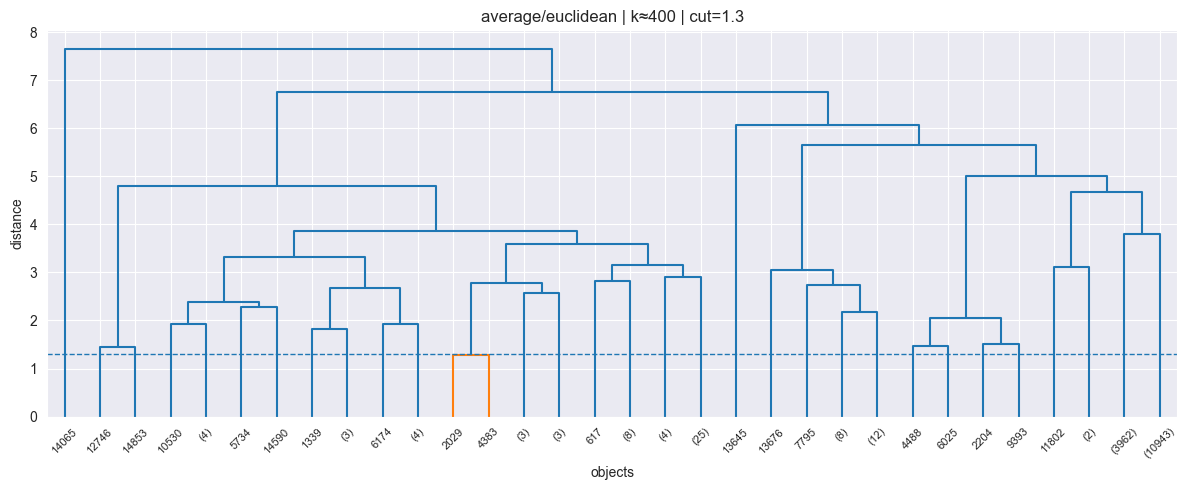

[Dendro[average,euclidean] k≈400]  F1-macro=0.2908 | ROC-AUC(macro, OvR)=0.8960 | PR-AUC(macro)=0.8212


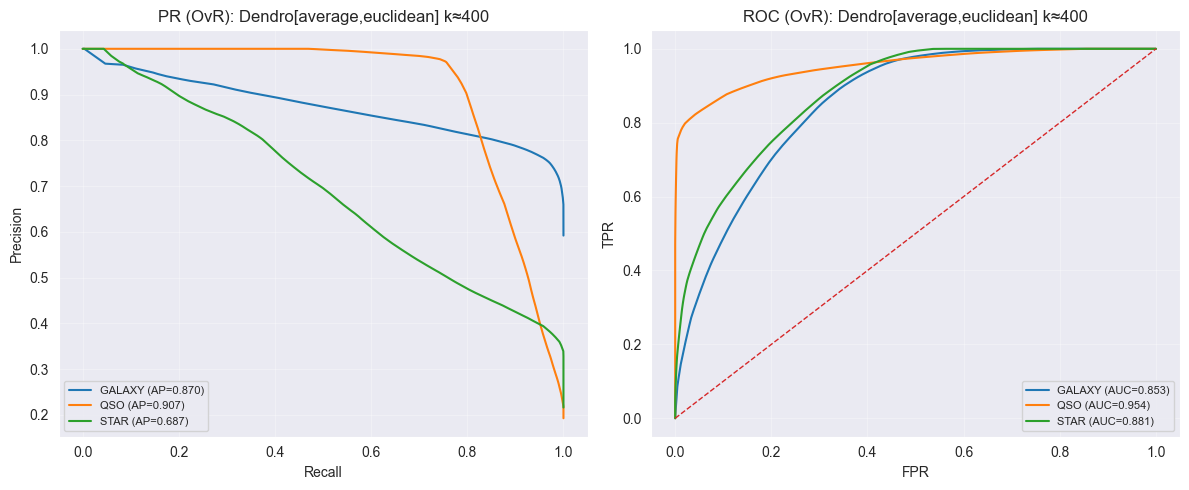

[Agg[average,euclidean]-full(k=3)]  F1-macro=0.2486 | ROC-AUC(macro, OvR)=0.5000 | PR-AUC(macro)=0.3334


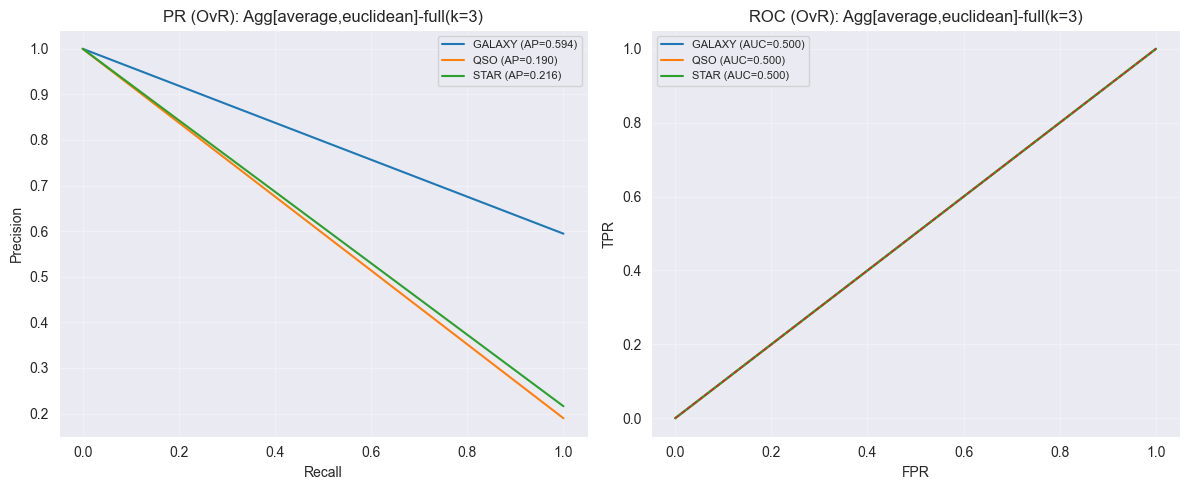

In [9]:

rows = []
k_true = 3

rng = np.random.RandomState(RANDOM_STATE)
n_d = min(15000, len(Xs))          # 15000..20000 — оптимально
idx = rng.choice(len(Xs), size=n_d, replace=False)
Xa, ya = Xs[idx], y[idx]

# кандидаты; напоминание: ward корректен только с 'euclidean'
dendro_cands = [
    ("single","euclidean"),
    ("complete","euclidean"),
    ("average","euclidean"),
    # ("weighted","euclidean"),
    # ("complete","cosine"),
    # ("average","cityblock"),
    # ("ward","euclidean"),
]

results = []
for link, metric in dendro_cands:
    if link == "ward" and metric != "euclidean":
        continue
    Z = linkage(Xa, method=link, metric=metric)
    k_pred, cut_h = largest_gap_cut(Z, relative=True)
    labels_tree = fcluster(Z, t=cut_h, criterion="distance")  # плоская разметка по порогу
    ami = AMI(ya, labels_tree)
    results.append((ami, link, metric, k_pred, cut_h, Z, labels_tree))

if not results:
    print("[Agg] no dendrogram candidate produced")
else:
    # лучший по AMI на сэмпле
    results.sort(key=lambda r: r[0], reverse=True)
    best_ami, best_link, best_metric, best_k, best_cut, Zbest, labels_best = results[0]
    print(f"[Agg] best dendrogram on sample: {best_link}/{best_metric}, k≈{best_k}, AMI={best_ami:.3f}")
    plot_dendro_with_cut(Zbest, best_cut, title=f"{best_link}/{best_metric} | k≈{best_k} | cut={best_cut:.3g}")

    # отчёт по дендро-срезу на сэмпле
    rows.append(eval_labels(f"Dendro[{best_link},{best_metric}] k≈{best_k}", ya, labels_best, Xa))
    report_and_plots(f"Dendro[{best_link},{best_metric}] k≈{best_k}", ya, labels_best, classes)

    # связность для полного набора
    n_ngb = max(10, int(min(30, math.sqrt(len(Xs)))))
    try:
        connectivity = kneighbors_graph(Xs, n_neighbors=n_ngb, include_self=False)
    except Exception:
        connectivity = None

    # финальный Agglomerative на всём X: фиксируем число кластеров для сопоставимости (k_true)
    n_clusters_full = k_true
    agg = AgglomerativeClustering(n_clusters=n_clusters_full, linkage=best_link, metric=best_metric,
                                  connectivity=connectivity if (best_link!="ward" or best_metric=="euclidean") else None)

    lab_full = agg.fit_predict(Xs)
    name = f"Agg[{best_link},{best_metric}]-full(k={n_clusters_full})"
    rows.append(eval_labels(name, y, lab_full, Xs))
    report_and_plots(name, y, lab_full, classes)

### === KMeans / MiniBatchKMeans ===

[KMeans] best k by silhouette on sample: 2
[KMeans(k=2)]  F1-macro=0.2486 | ROC-AUC(macro, OvR)=0.5000 | PR-AUC(macro)=0.3333


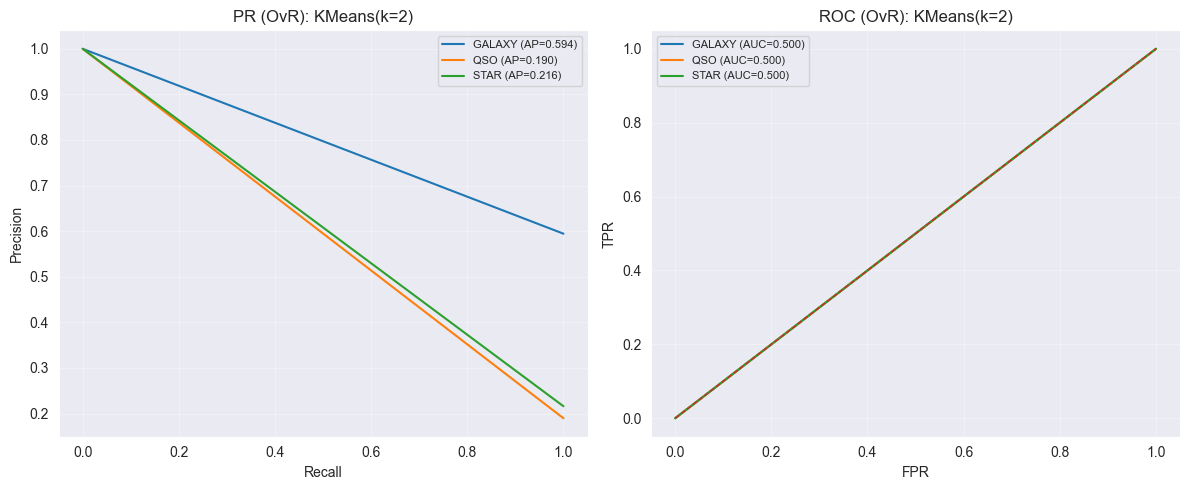

[MBKMeans(k=2)]  F1-macro=0.3354 | ROC-AUC(macro, OvR)=0.6287 | PR-AUC(macro)=0.3978


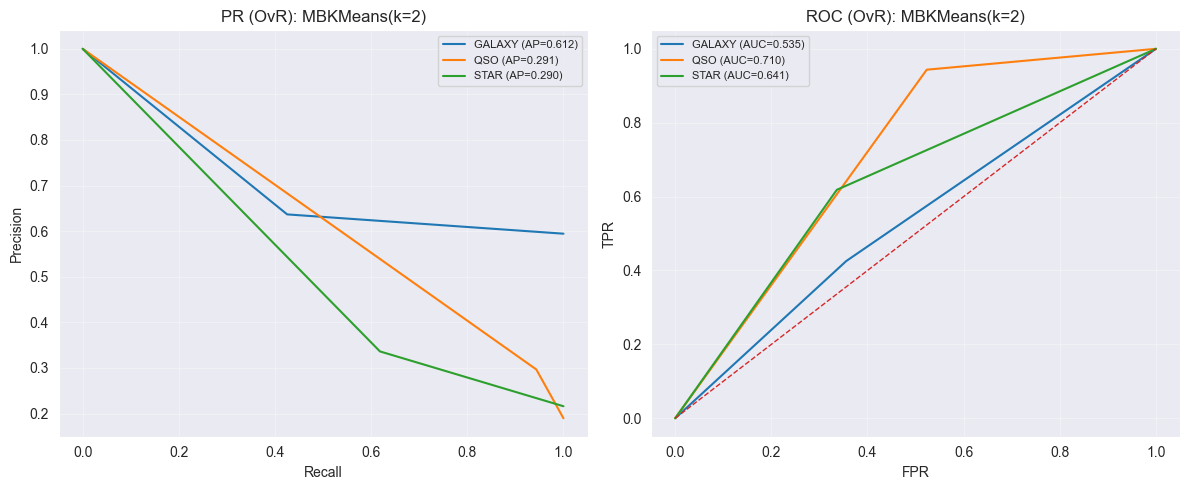

In [10]:
rng = np.random.RandomState(RANDOM_STATE)
sample_n = min(20000, len(Xs))
idx = rng.choice(len(Xs), size=sample_n, replace=False)
X_sm, y_sm = Xs[idx], y[idx]

k_grid = range(max(2, k_true-2), k_true+3)  # узкая сетка вокруг числа классов
best = None
for k in k_grid:
    km = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE, algorithm="elkan")
    lab = km.fit_predict(X_sm)
    if len(np.unique(lab)) < 2:
        continue
    sil = silhouette_score(X_sm, lab)
    best = (sil, k) if best is None or sil > best[0] else best

k_best = best[1] if best else k_true
print(f"[KMeans] best k by silhouette on sample: {k_best}")

# Запуск на всём: KMeans и MiniBatchKMeans
res_kmeans = {}
for name, model in [
    (f"KMeans(k={k_best})", KMeans(n_clusters=k_best, n_init=20, random_state=RANDOM_STATE, algorithm="elkan")),
    (f"MBKMeans(k={k_best})", MiniBatchKMeans(n_clusters=k_best, n_init=20, random_state=RANDOM_STATE, batch_size=4096)),
]:
    labels = model.fit_predict(Xs)
    rows.append(eval_labels(name, y, labels, Xs))
    res_kmeans[name] = report_and_plots(name, y, labels, classes)


### === SpectralClustering (на сэмпле) ===


[Spectral(RBF,g=0.0976,discretize)]  F1-macro=0.4039 | ROC-AUC(macro, OvR)=0.6326 | PR-AUC(macro)=0.4024


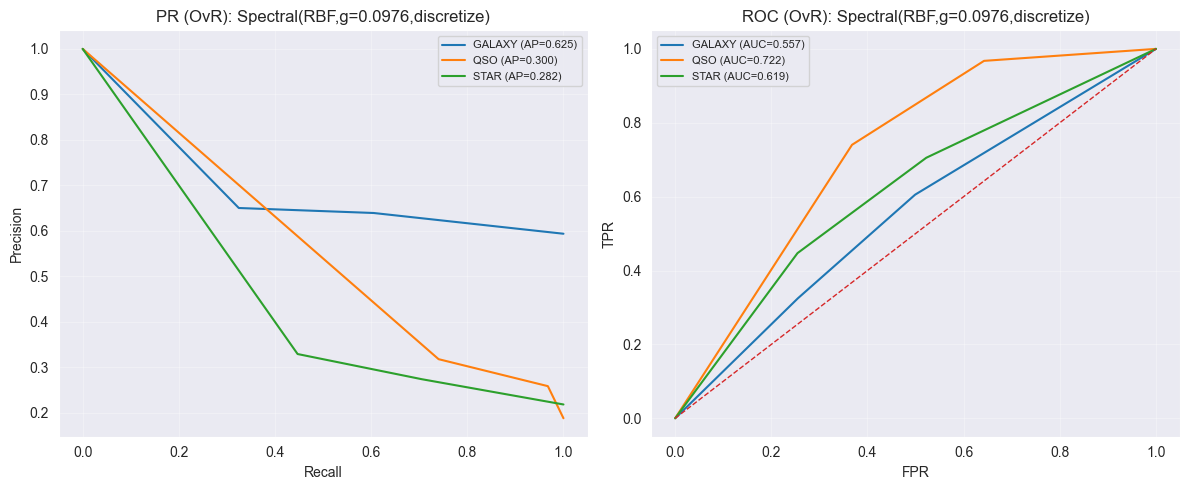

{'F1_macro': 0.40388525413345344,
 'ROC_AUC_macro': 0.632616680721817,
 'PR_AUC_macro': np.float64(0.40241906536527877),
 'C': array([[5783,  183, 2928],
        [4997, 1282, 1691],
        [7029, 4176, 1931]])}

In [11]:
if len(Xs) > SPECTRAL_MAX_N:
    rng = np.random.RandomState(RANDOM_STATE)
    idx = rng.choice(len(Xs), size=30000, replace=False)
    X_spec, y_spec = Xs[idx], y[idx]
else:
    X_spec, y_spec = Xs, y

gamma = median_heuristic_gamma(X_spec)

for assign in ("kmeans", "discretize"):
    try:
        spec = SpectralClustering(n_clusters=k_true, affinity="rbf",
                                  gamma=gamma, assign_labels=assign,
                                  random_state=RANDOM_STATE, n_init=10)
        labels = spec.fit_predict(X_spec)
        rows.append(eval_labels(f"Spectral(RBF,g={gamma:.3g},{assign})", y_spec, labels, X_spec))
    except Exception as e:
        rows.append(dict(name=f"Spectral({assign})", error=str(e)))
        
len(rows)
rows.append(eval_labels(f"Spectral(RBF,g={gamma:.3g},{assign})", y_spec, labels, X_spec))
report_and_plots(f"Spectral(RBF,g={gamma:.3g},{assign})", y_spec, labels, classes)

[DBSCAN(ms=5, eps=0.761)]  F1-macro=0.2497 | ROC-AUC(macro, OvR)=0.5054 | PR-AUC(macro)=0.3383


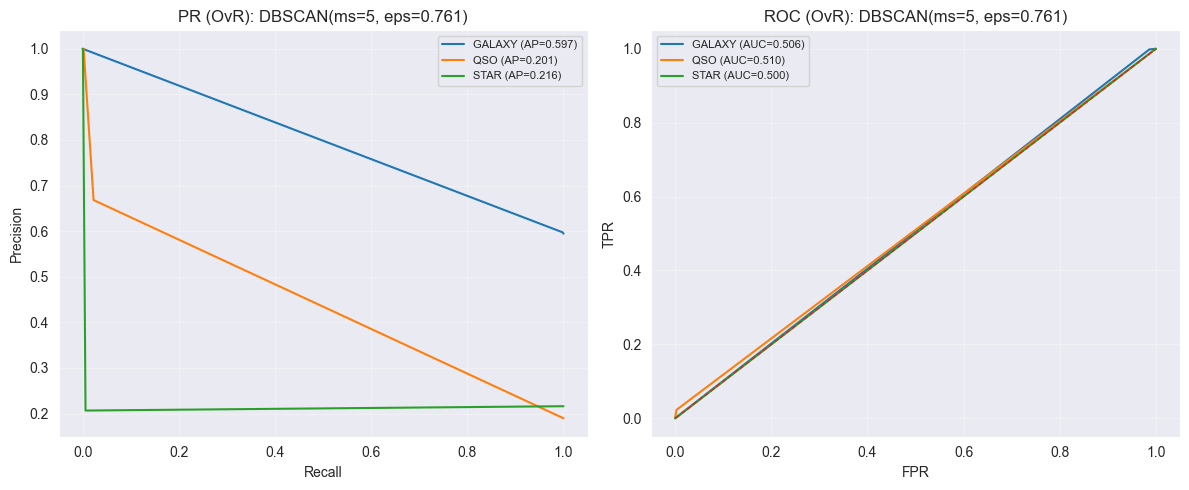

In [12]:
# === DBSCAN grid ===
ms_list = [5, 10, 20, 50, 500]
def knee_eps(X, min_samples=10, sample=20000, q=0.98):
    rng = np.random.RandomState(RANDOM_STATE)
    idx = rng.choice(len(X), size=min(sample, len(X)), replace=False)
    Xk = X[idx]
    nn = NearestNeighbors(n_neighbors=min_samples).fit(Xk)
    dist, _ = nn.kneighbors(Xk)
    kth = np.sort(dist[:, -1])
    # простая эвристика "сгиб": высокий квантиль (q ~ 0.98) как запасной вариант
    # (knee-детектор можно подключить позже)
    return float(np.quantile(kth, q))

db_best = None
for ms in ms_list:
    eps = knee_eps(Xs, min_samples=ms, sample=40000, q=0.98)
    model = DBSCAN(eps=eps, min_samples=ms)
    lab = model.fit_predict(Xs)
    score = AMI(y, lab)
    db_best = (score, ms, eps, lab) if db_best is None or score > db_best[0] else db_best

if db_best:
    score, ms, eps, lab = db_best
    name = f"DBSCAN(ms={ms}, eps={eps:.3f})"
    rows.append(eval_labels(name, y, lab, Xs))
    report_and_plots(name, y, lab, classes)
else:
    print("[DBSCAN] failed to find a workable config")


[OPTICS] best on sample: min_samples=5, xi=0.03
[OPTICS-xi(ms=5, xi=0.03)]  F1-macro=0.2526 | ROC-AUC(macro, OvR)=0.7730 | PR-AUC(macro)=0.6078


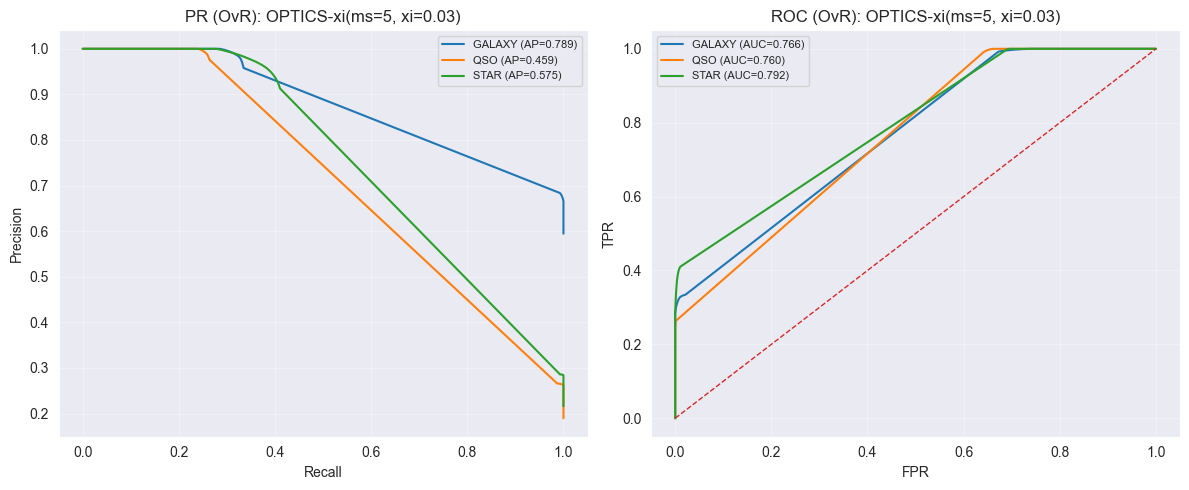

9

In [13]:
# === OPTICS ===
rng = np.random.RandomState(RANDOM_STATE)
idx = rng.choice(len(Xs), size=min(20000, len(Xs)), replace=False)
Xo, yo = Xs[idx], y[idx]

best = None
for ms in ms_list:
    for xi in (0.03, 0.05, 0.1):
        try:
            lab = OPTICS(min_samples=ms, xi=xi, cluster_method="xi", max_eps=np.inf).fit_predict(Xo)
            sc = AMI(yo, lab)
            best = (sc, ms, xi) if best is None or sc > best[0] else best
        except Exception:
            pass

if best:
    sc, ms, xi = best
    print(f"[OPTICS] best on sample: min_samples={ms}, xi={xi}")
    lab_full = OPTICS(min_samples=ms, xi=xi, cluster_method="xi", max_eps=np.inf).fit_predict(Xs)
    name = f"OPTICS-xi(ms={ms}, xi={xi})"
    rows.append(eval_labels(name, y, lab_full, Xs))
    report_and_plots(name, y, lab_full, classes)
else:
    print("[OPTICS] no config worked")
        
len(rows)

In [14]:
# === Results table ===
res = pd.DataFrame(rows)

# округление метрик
for c in ("AMI","ARI","hom","comp","v","NMI","sil"):
    if c in res:
        res[c] = pd.to_numeric(res[c], errors="coerce").round(4)

# сортировка
if {"AMI","ARI"}.issubset(res.columns):
    res = res.sort_values(["AMI","ARI","v"], ascending=False,
                          na_position="last").reset_index(drop=True)

display(res.head(20))
print(f"Всего конфигураций: {len(res)}")

# Сохранить при необходимости
# Path("cluster_bench_results.csv").write_text(res.to_csv(index=False), encoding="utf-8")
# print("[OK] Сохранено: cluster_bench_results.csv")

if len(res) and "name" in res.columns:
    print("[BEST]", res.iloc[0]["name"])

,name,k_pred,noise,AMI,ARI,hom,comp,v,NMI,sil
0,"Dendro[average,euclidean] k≈400",400,0,0.1522,0.0125,0.4990,0.0955,0.1603,0.1603,0.1469
1,"OPTICS-xi(ms=5, xi=0.03)",4198,65298,0.1156,0.0041,0.3159,0.0859,0.1350,0.1350,-0.4257
2,MBKMeans(k=2),2,0,0.1003,0.0404,0.0854,0.1215,0.1003,0.1003,0.2463
3,"Spectral(RBF,g=0.0976,discretize)",3,0,0.0672,0.0224,0.0714,0.0635,0.0672,0.0672,0.2243
4,"Spectral(RBF,g=0.0976,discretize)",3,0,0.0672,0.0224,0.0714,0.0635,0.0672,0.0672,0.2243
5,"Spectral(RBF,g=0.0976,kmeans)",3,0,0.0661,0.0190,0.0694,0.0632,0.0661,0.0661,0.2248
6,"DBSCAN(ms=5, eps=0.761)",9,605,0.0083,0.0084,0.0044,0.1006,0.0085,0.0085,0.1288
7,"Agg[average,euclidean]-full(k=3)",3,0,0.0000,0.0000,0.0000,0.1225,0.0001,0.0001,0.6276
8,KMeans(k=2),2,0,0.0000,0.0000,0.0000,0.1225,0.0000,0.0000,0.9940


Всего конфигураций: 9
[BEST] Dendro[average,euclidean] k≈400


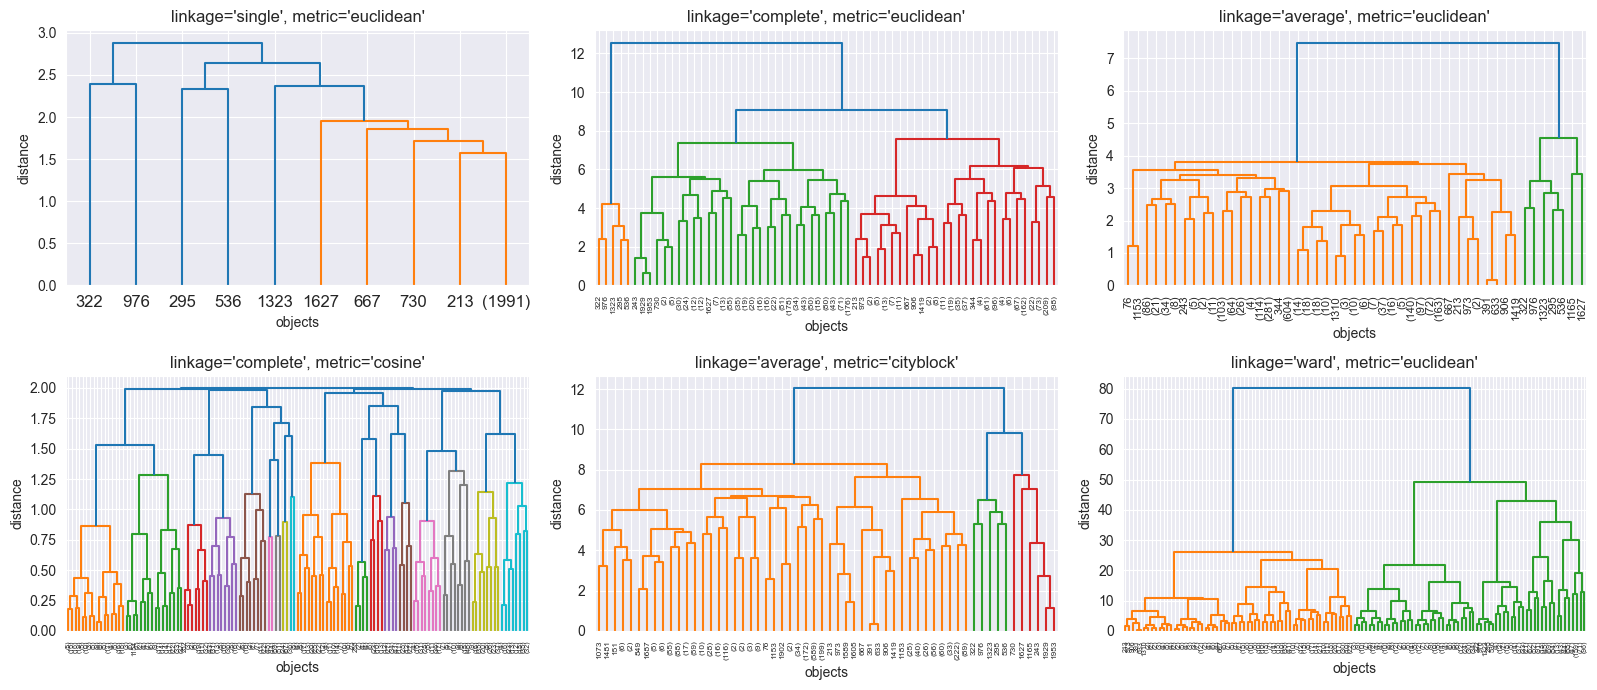

In [15]:
# === Dendrogram (optional, on sample) ===
# ВНИМАНИЕ: полные dendrogram на больших N — бесполезный обогреватель комнаты.
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

sample_n = min(2000, len(Xs))
rng = np.random
idx = rng.choice(len(Xs), size=sample_n, replace=False)
Xd = Xs[idx]; yd = y[idx]

dendro_select = [
    ("single",   "euclidean"),
    ("complete", "euclidean"),
    ("average",  "euclidean"),
    ("complete", "cosine"),
    ("average",  "cityblock"),
    ("ward",     "euclidean"),
]

fig_rows, fig_cols = 2, math.ceil(len(dendro_select)/2)
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(16, 7))
axes = axes.ravel()

for i, (method, metric) in enumerate(dendro_select):
    Z = linkage(Xd, method=method, metric=metric)
    dendrogram(Z, ax=axes[i], truncate_mode="level", p=6)
    axes[i].set_title(f"linkage='{method}', metric='{metric}'")
    axes[i].set_ylabel("distance"); axes[i].set_xlabel("objects")

for j in range(len(dendro_select), len(axes)):
    axes[j].axis("off")
plt.tight_layout(); plt.show()

['class_GALAXY', 'class_QSO', 'class_STAR']


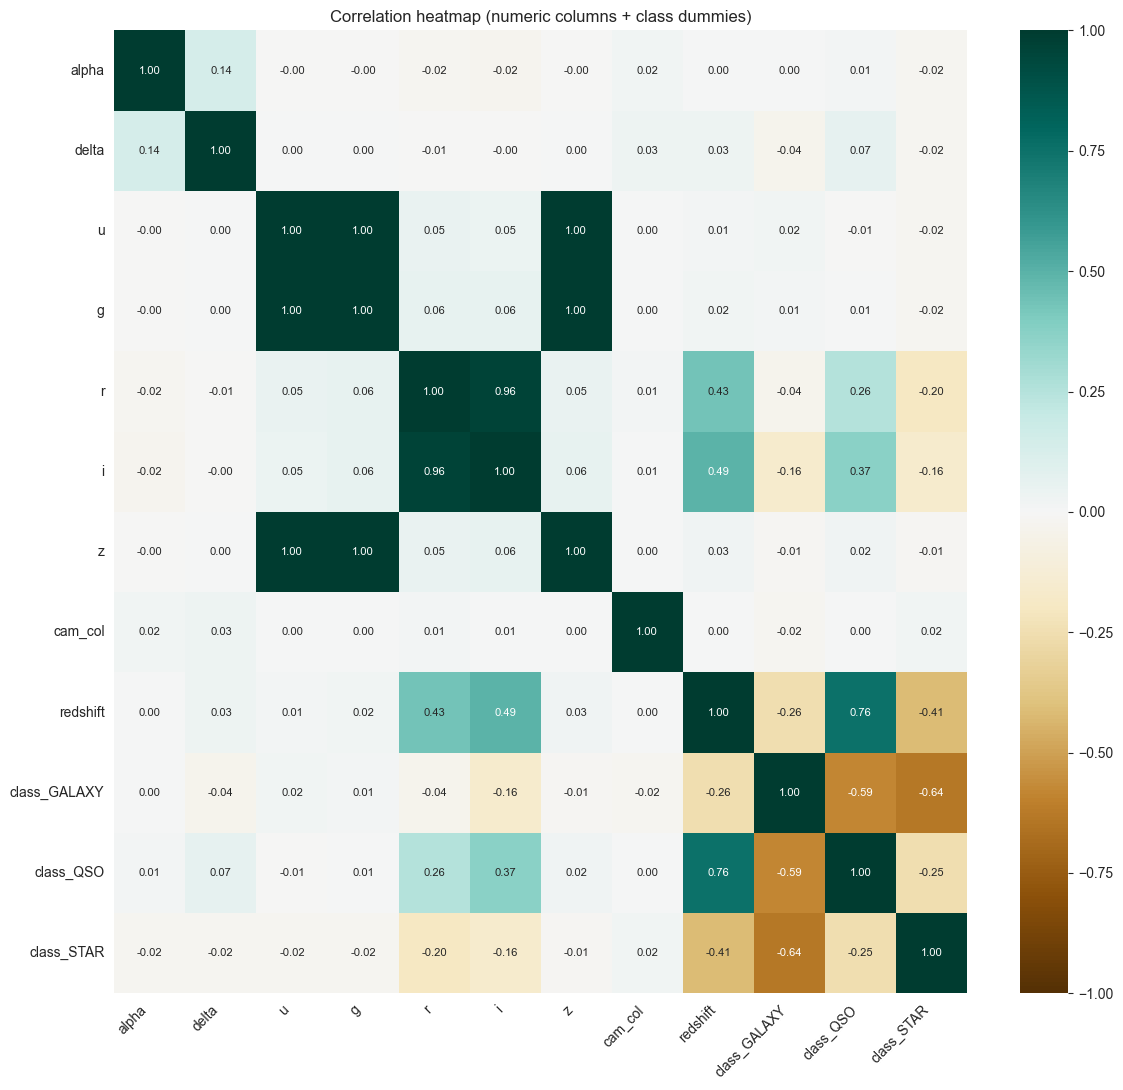

,alpha,delta,u,g,r,i,z,cam_col,redshift,class_GALAXY,class_QSO,class_STAR
alpha,1.000000,0.138691,-0.001532,-0.002423,-0.022083,-0.023580,-0.002918,0.019582,0.001667,0.004085,0.014261,-0.018461
delta,0.138691,1.000000,0.002074,0.003523,-0.006835,-0.004480,0.003630,0.032565,0.031638,-0.038297,0.065825,-0.017011
u,-0.001532,0.002074,1.000000,0.999311,0.054149,0.045730,0.998093,0.003548,0.014309,0.023129,-0.006590,-0.021321
g,-0.002423,0.003523,0.999311,1.000000,0.062387,0.056271,0.999161,0.003508,0.022954,0.014289,0.006015,-0.022780
r,-0.022083,-0.006835,0.054149,0.062387,1.000000,0.962868,0.053677,0.008480,0.433241,-0.037997,0.255142,-0.197722
i,-0.023580,-0.004480,0.045730,0.056271,0.962868,1.000000,0.055994,0.007615,0.492383,-0.160379,0.370459,-0.161545
z,-0.002918,0.003630,0.998093,0.999161,0.053677,0.055994,1.000000,0.003365,0.030380,-0.008382,0.024361,-0.013206
cam_col,0.019582,0.032565,0.003548,0.003508,0.008480,0.007615,0.003365,1.000000,0.000097,-0.020569,0.003317,0.021384
redshift,0.001667,0.031638,0.014309,0.022954,0.433241,0.492383,0.030380,0.000097,1.000000,-0.256925,0.756649,-0.414245
class_GALAXY,0.004085,-0.038297,0.023129,0.014289,-0.037997,-0.160379,-0.008382,-0.020569,-0.256925,1.000000,-0.585624,-0.635371


In [16]:
# [HEATMAP WITH CLASS DUMMIES — SHORT]

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

FEATS = Xdf.copy()

# 1) Получаем числовой вектор y (если есть) или маппим из df["class"]
if "y" in globals() and len(FEATS) == len(y):
    y_vec = np.asarray(y, dtype=int)
    # список имён классов
    CLS = list(classes) if "classes" in globals() else sorted(np.unique(y_vec).tolist())
else:
    # берём классы из 'classes' если заданы, иначе из df
    if "classes" in globals():
        CLS = list(classes)
        CLS_U = [c.upper() for c in CLS]
    else:
        CLS = sorted(FEATS["class"].astype(str).str.strip().str.upper().unique().tolist())
        CLS_U = CLS
    name2id = {name:i for i, name in enumerate(CLS_U)}
    y_vec = FEATS["class"].astype(str).str.strip().str.upper().map(name2id).astype(int).to_numpy()

# 2) Удаляем исходный столбец классов и добавляем 3 индикатора (OvR)
FEATS = FEATS.drop(columns=["class"], errors="ignore")
for k, c in enumerate(CLS):
    FEATS[f"class_{c}"] = (y_vec == k).astype(int)

# 3) Считаем корреляции Pearson по всем ЧИСЛОВЫМ столбцам (ID останутся, если числовые)
NUM = FEATS.select_dtypes(include=[np.number])
corr = NUM.corr(method="pearson")

# (опционально убедимся, что классы на месте)
print([c for c in corr.columns if c.startswith("class_")])

# 3) теплокарта без масок, с числами
n = len(COLS)
plt.figure(figsize=(max(8, 0.5*n + 3), max(6, 0.5*n + 2)))
ax = sns.heatmap(corr, vmin=-1, vmax=1, cmap="BrBG",
                 annot=True, fmt=".2f", annot_kws={"size":8}, linewidths=0)
ax.set_title("Correlation heatmap (numeric columns + class dummies)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout(); plt.show()
corr

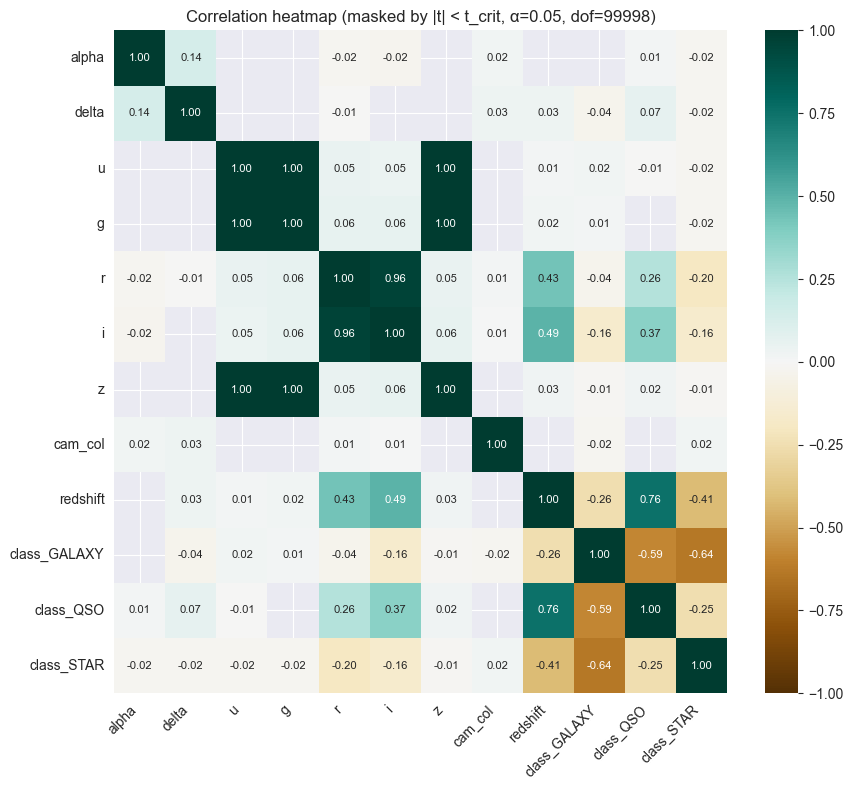

In [17]:
from scipy import stats
# corr: матрица корреляций (из твоего кода)
# NUM:  числовой DataFrame, по которому считали corr
n = len(NUM)                 # для Xdf без NaN по колонкам это корректно
dfree = n - 2

# t-статистика для Pearson (и допуск для Spearman как приближение)
T = corr * np.sqrt(dfree / np.maximum(1 - corr**2, 1e-12))
alpha = 0.05                 # уровень значимости (двусторонний)
tcrit = stats.t.ppf(1 - alpha/2, df=dfree)

# маска: True = скрыть клетку как "не значимо"
mask = T.abs() < tcrit
# диагональ оставим видимой (r=1, t=∞)
np.fill_diagonal(mask.values, False)

# перерисуем теплокарту корреляций c маской значимости
cols = corr.columns.tolist()
ncols = len(cols)
plt.figure(figsize=(max(8, 0.5*ncols + 3), max(6, 0.5*ncols + 2)))
ax = sns.heatmap(
    corr, mask=mask, vmin=-1, vmax=1, cmap="BrBG",
    annot=True, fmt=".2f", annot_kws={"size":8}, linewidths=0
)
ax.set_title(f"Correlation heatmap (masked by |t| < t_crit, α={alpha}, dof={dfree})")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout(); plt.show()

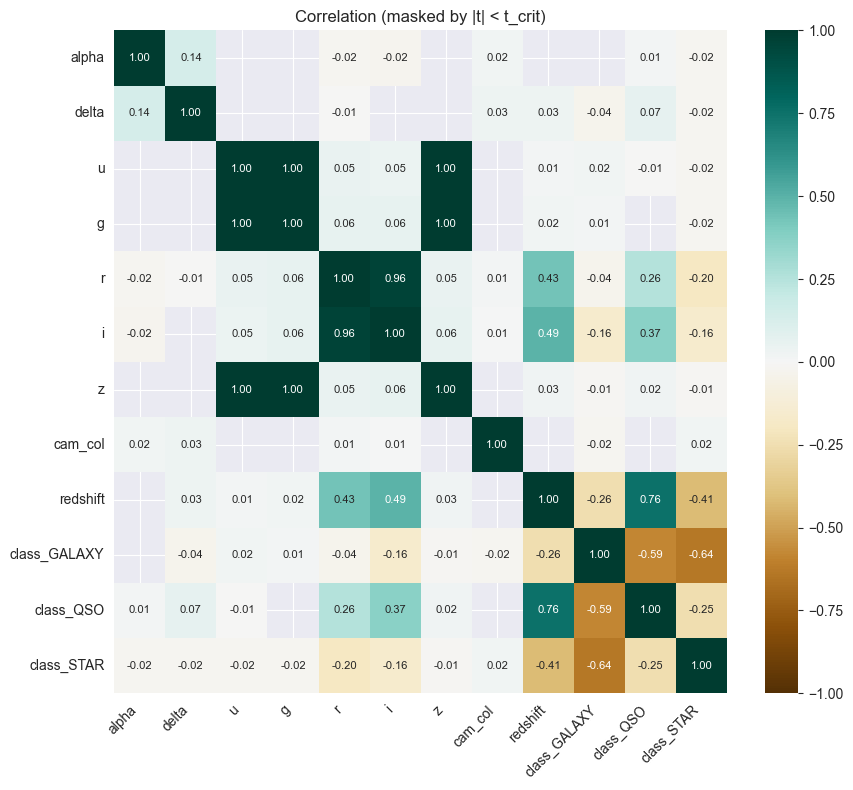

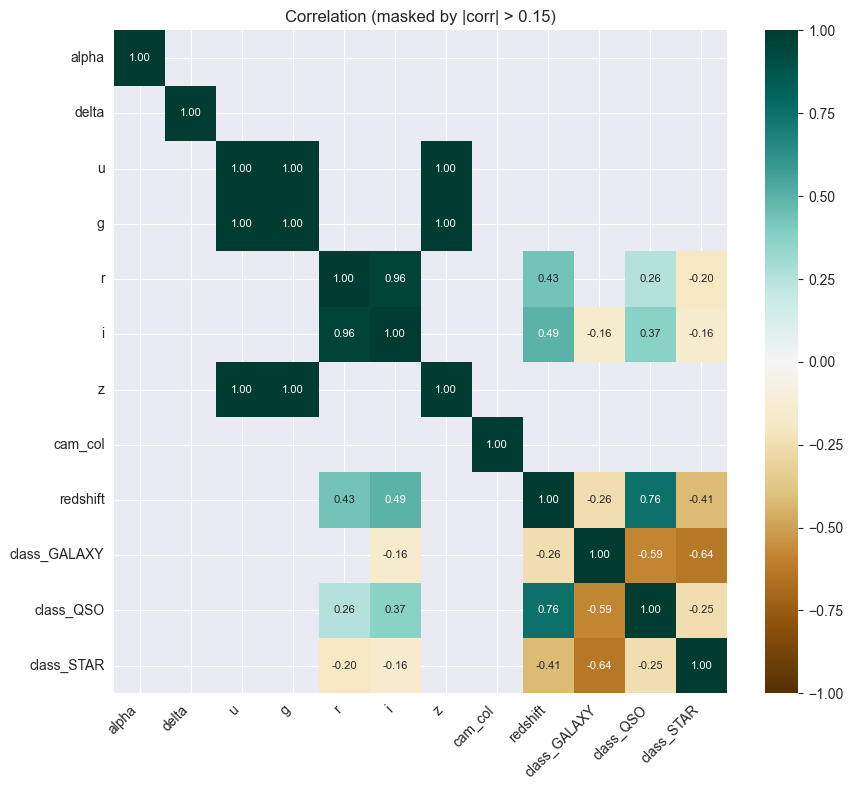

In [18]:
n = len(NUM)
dfree = n - 2

# 1) Маска по значимости (двусторонний тест)
T = corr * np.sqrt(dfree / np.maximum(1 - corr**2, 1e-12))
alpha = 0.05
tcrit = stats.t.ppf(1 - alpha/2, df=dfree)
mask_sig = T.abs() < tcrit
np.fill_diagonal(mask_sig.values, False)

plt.figure(figsize=(max(8, 0.5*len(corr)+3), max(6, 0.5*len(corr)+2)))
ax = sns.heatmap(corr, mask=mask_sig, vmin=-1, vmax=1, cmap="BrBG",
                 annot=True, fmt=".2f", annot_kws={"size":8}, linewidths=0)
ax.set_title(f"Correlation (masked by |t| < t_crit)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout(); plt.show()

# 2) Маска по величине эффекта: показываем только |corr| >= 0.15
thr = 0.15
mask_thr = corr.abs() < thr
np.fill_diagonal(mask_thr.values, False)

plt.figure(figsize=(max(8, 0.5*len(corr)+3), max(6, 0.5*len(corr)+2)))
ax = sns.heatmap(corr, mask=mask_thr, vmin=-1, vmax=1, cmap="BrBG",
                 annot=True, fmt=".2f", annot_kws={"size":8}, linewidths=0)
ax.set_title(f"Correlation (masked by |corr| > {thr})")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout(); plt.show()

## Dimensionality reduction для классификации

Гипотезы:
1. Удаление части признаков (через PCA или отбор по важности) позволит упростить модель без значимой потери качества.
2. PCA должно сильнее влиять на линейные модели, но даже для RandomForest возможно уменьшение времени обучения при близком качестве.

Ниже — эксперименты с RandomForest как лучшим классификатором.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import time

In [13]:

# Базовая матрица признаков и целевая
X_full = Xdf.values
y_full = y

# Чтобы не убить машину, ограничимся сэмплом
rng = np.random.RandomState(RANDOM_STATE)
max_n = 5000
if len(X_full) > max_n:
    idx = rng.choice(len(X_full), size=max_n, replace=False)
    X_clf = X_full[idx]
    y_clf = y_full[idx]
else:
    X_clf = X_full
    y_clf = y_full

X_train, X_test, y_train, y_test = train_test_split(
    X_clf, y_clf,
    test_size=0.2,
    stratify=y_clf,
    random_state=RANDOM_STATE
)

# Лучший RandomForest из HyperParamTraining (по топ-строчкам таблицы)
best_rf_params = dict(
    n_estimators=50, # Можно попробовать сделать больше
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features="sqrt",
    bootstrap=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# === Бейслайн без понижения размерности ===
rf_base = RandomForestClassifier(**best_rf_params)

rf_base.fit(X_train, y_train)

y_pred_base = rf_base.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_base)
baseline_f1 = f1_score(y_test, y_pred_base, average="macro")

print(f"[BASE RF] acc={baseline_acc:.4f}, F1_macro={baseline_f1:.4f}")

# === PCA -> RF ===
results_pca = []

n_features = X_train.shape[1]
grid_components = [1, 2, 3, 4, 5, 7, 8]
grid_components = [k for k in grid_components if k < n_features]

for k in grid_components:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=k, random_state=RANDOM_STATE)),
        ("rf", RandomForestClassifier(**best_rf_params)),
    ])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    results_pca.append(dict(
        n_components=k,
        acc=acc,
        f1_macro=f1,
    ))

    print(f"[PCA k={k:2d}] acc={acc:.4f}, F1_macro={f1:.4f}")

df_pca_rf = pd.DataFrame(results_pca).sort_values("f1_macro", ascending=False)
display(df_pca_rf)

[BASE RF] acc=0.9770, F1_macro=0.9728
[PCA k= 1] acc=0.5250, F1_macro=0.3712
[PCA k= 2] acc=0.5920, F1_macro=0.4476
[PCA k= 3] acc=0.6880, F1_macro=0.5788
[PCA k= 4] acc=0.7700, F1_macro=0.7024
[PCA k= 5] acc=0.7980, F1_macro=0.7322
[PCA k= 7] acc=0.9000, F1_macro=0.8858
[PCA k= 8] acc=0.9090, F1_macro=0.8948


,n_components,acc,f1_macro
6,8,0.909,0.894781
5,7,0.900,0.885832
4,5,0.798,0.732215
3,4,0.770,0.702426
2,3,0.688,0.578775
1,2,0.592,0.447633
0,1,0.525,0.371217


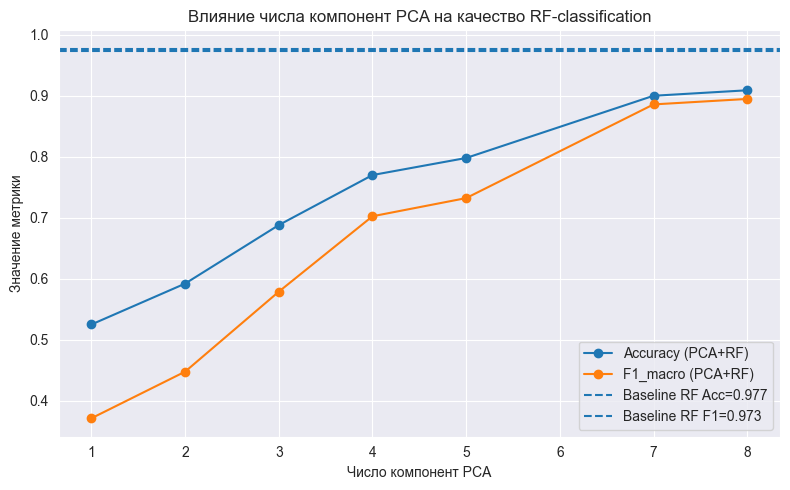

In [27]:
df_plot = df_pca_rf.sort_values("n_components")

plt.figure(figsize=(8, 5))
plt.plot(df_plot["n_components"], df_plot["acc"], marker="o", label="Accuracy (PCA+RF)")
plt.plot(df_plot["n_components"], df_plot["f1_macro"], marker="o", label="F1_macro (PCA+RF)")

# базовые линии
plt.axhline(baseline_acc, linestyle="--", label=f"Baseline RF Acc={baseline_acc:.3f}")
plt.axhline(baseline_f1, linestyle="--", label=f"Baseline RF F1={baseline_f1:.3f}")

plt.xlabel("Число компонент PCA")
plt.ylabel("Значение метрики")
plt.title("Влияние числа компонент PCA на качество RF-classification")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

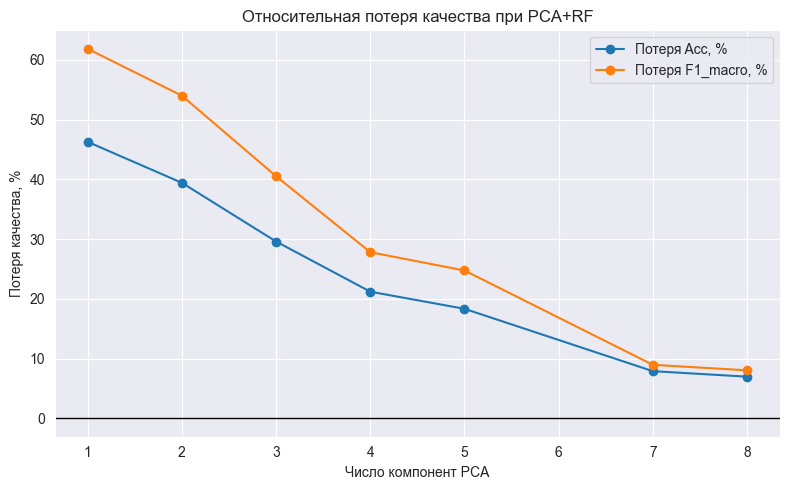

In [29]:
df_rel = df_plot.copy()
df_rel["acc_drop"] = (baseline_acc - df_rel["acc"]) / baseline_acc * 100
df_rel["f1_drop"] = (baseline_f1 - df_rel["f1_macro"]) / baseline_f1 * 100

plt.figure(figsize=(8, 5))
plt.plot(df_rel["n_components"], df_rel["acc_drop"], marker="o", label="Потеря Acc, %")
plt.plot(df_rel["n_components"], df_rel["f1_drop"], marker="o", label="Потеря F1_macro, %")

plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Число компонент PCA")
plt.ylabel("Потеря качества, %")
plt.title("Относительная потеря качества при PCA+RF")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
results_pca_var = []

feature_names = np.array(Xdf.columns)

for var in [0.8, 0.9, 0.95, 0.99]:
    pca = PCA(n_components=var, random_state=RANDOM_STATE)
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", pca),
        ("rf", RandomForestClassifier(**best_rf_params)),
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    pca_step = pipe.named_steps["pca"]
    k_eff = pca_step.n_components_

    # --- считаем "важность" исходных фич для первых k_eff компонент ---
    comps = pca_step.components_           # shape: (k_eff, n_features)
    var_ratio = pca_step.explained_variance_ratio_  # len = k_eff
    
    # взвешенный вклад: |loadings| * долю дисперсии и суммируем по компонентам
    contrib = (np.abs(comps) * var_ratio[:, None]).sum(axis=0)  # shape: (n_features,)
    idx_sorted = np.argsort(contrib)[::-1]

    top_n = min(5, len(feature_names))
    top_features = feature_names[idx_sorted[:top_n]]

    results_pca_var.append(dict(
        var=var,
        n_components=k_eff,
        acc=acc,
        f1_macro=f1,
        top_features=", ".join(top_features)
    ))
    
    print(
        f"var={var}, k={k_eff}, "
        f"acc={acc:.4f}, F1={f1:.4f}"
    )
    print("  Топ фич по вкладу в первые компоненты:", ", ".join(top_features))

df_pca_var = pd.DataFrame(results_pca_var).sort_values("var")
display(df_pca_var)

var=0.8, k=4, acc=0.7750, F1=0.7065
  Топ фич по вкладу в первые компоненты: g, u, redshift, z, i
var=0.9, k=5, acc=0.8090, F1=0.7409
  Топ фич по вкладу в первые компоненты: redshift, u, g, z, i
var=0.95, k=6, acc=0.8820, F1=0.8624
  Топ фич по вкладу в первые компоненты: redshift, u, g, z, i
var=0.99, k=7, acc=0.9000, F1=0.8861
  Топ фич по вкладу в первые компоненты: u, redshift, g, z, i


,var,n_components,acc,f1_macro,top_features
0,0.80,4,0.775,0.706527,"g, u, redshift, z, i"
1,0.90,5,0.809,0.740862,"redshift, u, g, z, i"
2,0.95,6,0.882,0.862395,"redshift, u, g, z, i"
3,0.99,7,0.900,0.886109,"u, redshift, g, z, i"


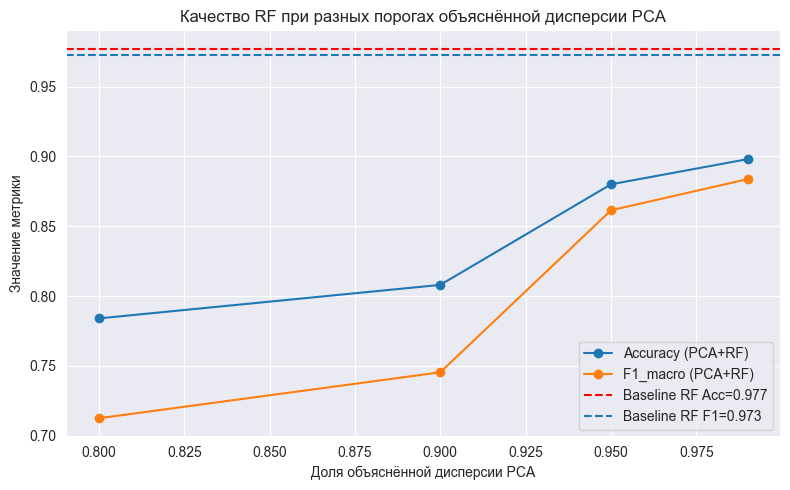

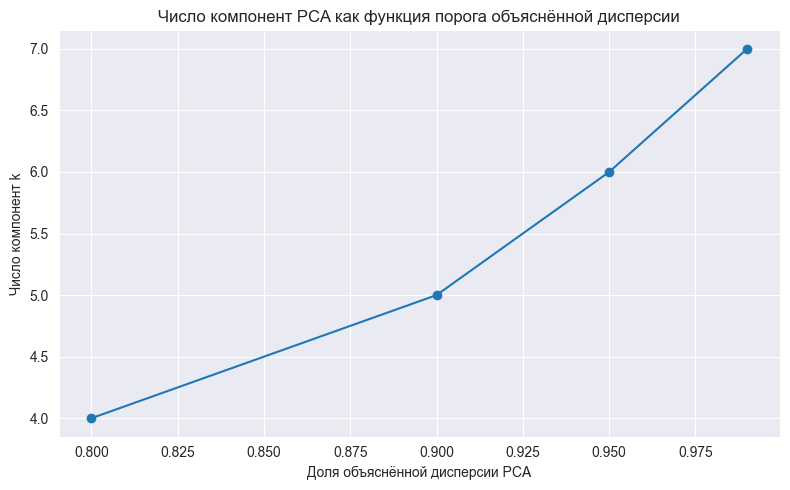

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(df_pca_var["var"], df_pca_var["acc"], marker="o", label="Accuracy (PCA+RF)")
plt.plot(df_pca_var["var"], df_pca_var["f1_macro"], marker="o", label="F1_macro (PCA+RF)")

plt.axhline(baseline_acc, linestyle="--", label=f"Baseline RF Acc={baseline_acc:.3f}", color="red")
plt.axhline(baseline_f1, linestyle="--", label=f"Baseline RF F1={baseline_f1:.3f}")

plt.xlabel("Доля объяснённой дисперсии PCA")
plt.ylabel("Значение метрики")
plt.title("Качество RF при разных порогах объяснённой дисперсии PCA")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(df_pca_var["var"], df_pca_var["n_components"], marker="o")
plt.xlabel("Доля объяснённой дисперсии PCA")
plt.ylabel("Число компонент k")
plt.title("Число компонент PCA как функция порога объяснённой дисперсии")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
from sklearn.feature_selection import SelectFromModel
import numpy as np

rf_full = RandomForestClassifier(**best_rf_params)
rf_full.fit(X_train, y_train)

selector = SelectFromModel(rf_full, prefit=True, threshold="median")

X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

rf_sel = RandomForestClassifier(**best_rf_params)
rf_sel.fit(X_train_sel, y_train)
y_pred_sel = rf_sel.predict(X_test_sel)

print(X_train.shape, "->", X_train_sel.shape)
print("ACC/F1:",
      accuracy_score(y_test, y_pred_sel),
      f1_score(y_test, y_pred_sel, average="macro"))

# --- какие колонки оставили ---
feature_names = np.array(Xdf.columns)  # те же, что были в X_full
mask = selector.get_support()
selected_features = feature_names[mask]

print("Выбранные признаки (SelectFromModel):")
for name in selected_features:
    print(" -", name)

(4000, 9) -> (4000, 5)
ACC/F1: 0.975 0.9705507307285499
Выбранные признаки (SelectFromModel):
 - u
 - g
 - i
 - z
 - redshift


In [38]:
importances = rf_full.feature_importances_
df_fs = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances,
        "selected": mask
    })
    .sort_values("importance", ascending=False)
)
display(df_fs)

,feature,importance,selected
8,redshift,0.672717,True
6,z,0.099996,True
3,g,0.069688,True
2,u,0.054171,True
5,i,0.052952,True
4,r,0.031813,False
0,alpha,0.008047,False
1,delta,0.007672,False
7,cam_col,0.002945,False


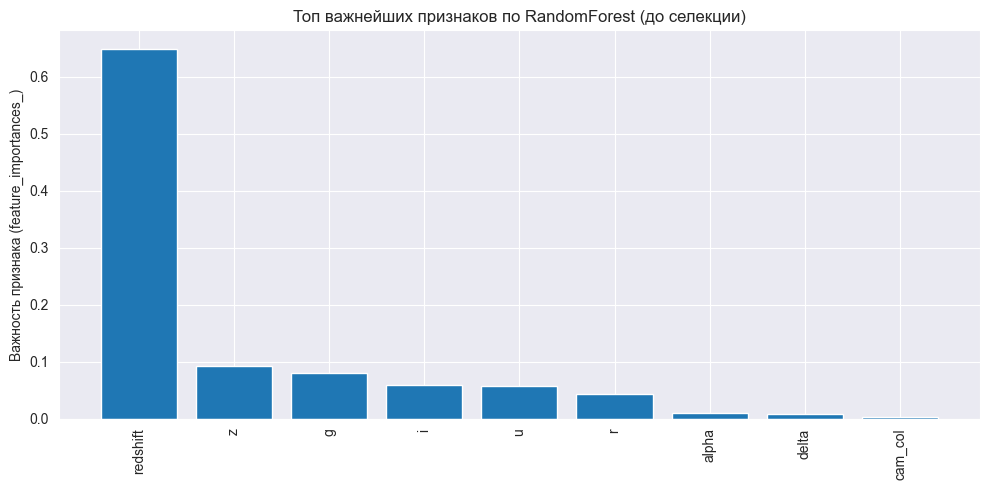

In [33]:
feature_names = np.array(Xdf.columns)
importances = rf_full.feature_importances_

# Маска выбранных фич
support_mask = selector.get_support()

# 1) Топ-важности (можно взять, например, топ-20)
idx_sorted = np.argsort(importances)[::-1]
top_k = 20
idx_top = idx_sorted[:top_k]

plt.figure(figsize=(10, 5))
plt.bar(range(len(idx_top)), importances[idx_top])
plt.xticks(range(len(idx_top)), feature_names[idx_top], rotation=90)
plt.ylabel("Важность признака (feature_importances_)")
plt.title("Топ важнейших признаков по RandomForest (до селекции)")
plt.tight_layout()
plt.show()

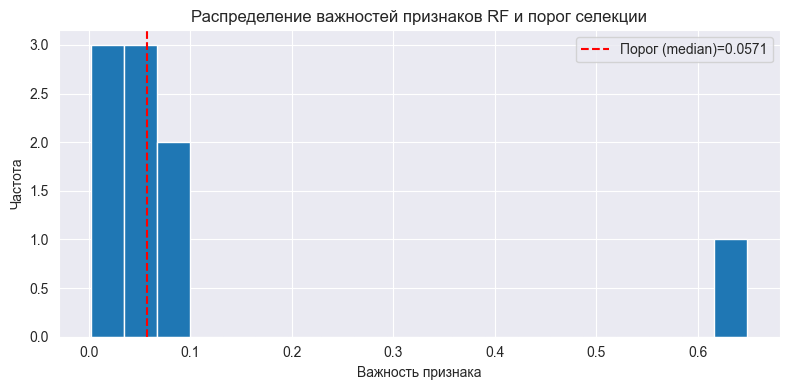

In [34]:
median_thr = np.median(importances)

plt.figure(figsize=(8, 4))
plt.hist(importances, bins=20)
plt.axvline(median_thr, color="red", linestyle="--", label=f"Порог (median)={median_thr:.4f}")
plt.xlabel("Важность признака")
plt.ylabel("Частота")
plt.title("Распределение важностей признаков RF и порог селекции")
plt.legend()
plt.tight_layout()
plt.show()

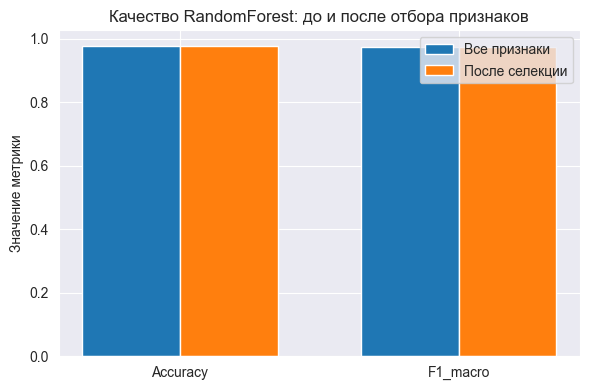

Baseline: ACC=0.9770, F1=0.9728
Selected: ACC=0.9770, F1=0.9729


In [35]:
acc_sel = accuracy_score(y_test, y_pred_sel)
f1_sel = f1_score(y_test, y_pred_sel, average="macro")

metrics = ["Accuracy", "F1_macro"]
baseline_vals = [baseline_acc, baseline_f1]
selected_vals = [acc_sel, f1_sel]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, baseline_vals, width=width, label="Все признаки")
plt.bar(x + width/2, selected_vals, width=width, label="После селекции")

plt.xticks(x, metrics)
plt.ylabel("Значение метрики")
plt.title("Качество RandomForest: до и после отбора признаков")
plt.legend()
plt.tight_layout()
plt.show()

print("Baseline: ACC={:.4f}, F1={:.4f}".format(baseline_acc, baseline_f1))
print("Selected: ACC={:.4f}, F1={:.4f}".format(acc_sel, f1_sel))

In [16]:
from sklearn.feature_selection import RFECV

rf_base = RandomForestClassifier(**best_rf_params)

rfecv = RFECV(
    estimator=rf_base,
    step=1,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1
)
rfecv.fit(X_train, y_train)

print("Оптимальное число фич:", rfecv.n_features_)

X_train_rfe = rfecv.transform(X_train)
X_test_rfe = rfecv.transform(X_test)

rf_rfe = RandomForestClassifier(**best_rf_params)
rf_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = rf_rfe.predict(X_test_rfe)

print("ACC/F1:", accuracy_score(y_test, y_pred_rfe), f1_score(y_test, y_pred_rfe, average="macro"))

Оптимальное число фич: 9
ACC/F1: 0.976 0.9719188385967525


In [17]:
print("n_features:", X_train.shape[1])

pipe_dbg = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5, random_state=RANDOM_STATE))
])
pipe_dbg.fit(X_train, y_train)

pca = pipe_dbg.named_steps["pca"]
print("explained_variance_ratio_:", pca.explained_variance_ratio_)
print("cumulative:", pca.explained_variance_ratio_.cumsum())

n_features: 9
explained_variance_ratio_: [0.49457128 0.1276836  0.11001662 0.10705325 0.09646719]
cumulative: [0.49457128 0.62225488 0.7322715  0.83932475 0.93579194]


# === Feature selection: отбор по feature_importances_ RandomForest ===



In [18]:

# Обучаем RF на полном наборе признаков, чтобы оценить важность
rf_imp = RandomForestClassifier(**best_rf_params)
rf_imp.fit(X_train, y_train)

feat_names = np.array(Xdf.columns)
importances = rf_imp.feature_importances_

imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("Топ-15 самых важных признаков:")
display(imp_df.head(15))

n_features_total = X_train.shape[1]
top_ks = [5, 10, 15, 20]
top_ks = [k for k in top_ks if k <= n_features_total]

feat_index = {f: i for i, f in enumerate(feat_names)}

fs_results = []

for k in top_ks:
    top_features = imp_df.head(k)["feature"].values
    cols_idx = [feat_index[f] for f in top_features]

    X_train_k = X_train[:, cols_idx]
    X_test_k = X_test[:, cols_idx]

    rf_k = RandomForestClassifier(**best_rf_params)

    t0 = time.time()
    rf_k.fit(X_train_k, y_train)
    t_fit = time.time() - t0

    y_pred_k = rf_k.predict(X_test_k)
    acc_k = accuracy_score(y_test, y_pred_k)
    f1_k = f1_score(y_test, y_pred_k, average="macro")

    fs_results.append(dict(
        n_features=k,
        acc=acc_k,
        f1_macro=f1_k,
        fit_time=t_fit
    ))

    print(f"[FS k={k:2d}] acc={acc_k:.4f}, F1_macro={f1_k:.4f}, fit_time={t_fit:.2f} s")

df_fs_rf = pd.DataFrame(fs_results).sort_values("n_features")
display(df_fs_rf)

Топ-15 самых важных признаков:


,feature,importance
8,redshift,0.636837
6,z,0.105006
2,u,0.069656
5,i,0.065202
3,g,0.065164
4,r,0.036559
0,alpha,0.009649
1,delta,0.009087
7,cam_col,0.002839


[FS k= 5] acc=0.9740, F1_macro=0.9694, fit_time=0.06 s


,n_features,acc,f1_macro,fit_time
0,5,0.974,0.969431,0.058072


## Dimensionality reduction для регрессии (прогноз redshift)

Задача: оценить, как понижение размерности влияет на качество регрессии redshift 
по фотометрическим признакам u, g, r, i, z.
Бейслайн — Ridge-регрессия без понижения размерности.

In [45]:

# Берём те же данные df, что и в начале ноутбука
df_reg = df.copy()


color_features = ['u', 'g', 'r', 'i', 'z']
target_reg = 'redshift'

df_reg = df_reg[(df_reg[color_features] != -9999).all(axis=1)].copy()
df_reg = df_reg.dropna(subset=[target_reg, "class"])  # на всякий случай

# 1. Классы -> индексы
class_map = {"STAR": 0, "GALAXY": 1, "QSO": 2}
df_reg["class_idx"] = df_reg["class"].map(class_map)

# 2. Цветовые индексы
df_reg["u_g"] = df_reg["u"] - df_reg["g"]
df_reg["g_r"] = df_reg["g"] - df_reg["r"]
df_reg["r_i"] = df_reg["r"] - df_reg["i"]
df_reg["i_z"] = df_reg["i"] - df_reg["z"]

base_features   = ["u", "g", "r", "i", "z"]
color_feats     = ["u_g", "g_r", "r_i", "i_z"]
all_num_features = base_features + color_feats

class_feature_names = [f"class_{c}" for c in ["STAR", "GALAXY", "QSO"]]
all_features_ext = all_num_features + class_feature_names
# Фиксируем индексы и сэмпл
n_objects = len(df_reg)
idx_all = np.arange(n_objects)

max_n_reg = 100000
if n_objects > max_n_reg:
    idx_all = rng.choice(idx_all, size=max_n_reg, replace=False)

# 4. Строим X и y ПО ЭТИМ ЖЕ ИНДЕКСАМ
X_num = df_reg.iloc[idx_all][all_num_features].values
class_idx = df_reg.iloc[idx_all]["class_idx"].values
y_reg = df_reg.iloc[idx_all][target_reg].values

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
class_ohe = ohe.fit_transform(class_idx.reshape(-1, 1))

X_reg_ext = np.hstack([X_num, class_ohe])

print("Final feature shape:", X_reg_ext.shape)

# 5. Сплит
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg_ext, y_reg,
    test_size=0.25,
    random_state=RANDOM_STATE
)

print("Train shape:", X_train_r.shape, "Test shape:", X_test_r.shape)

Final feature shape: (99999, 12)
Train shape: (74999, 12) Test shape: (25000, 12)


In [46]:
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [105]:

from sklearn.linear_model import LogisticRegression


def reg_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return r2, mse, rmse, mae

# Конфигурации моделей: минимум 5, по факту 6 штук
model_configs = {
    # "LinearRegression": {
    #     "estimator": LinearRegression(),
    #     "param_grid": {  # по сути, почти без тюнинга, baseline
    #         "model__fit_intercept": [True, False]
    #     },
    #     "use_scaler": True,
    # },
    # "Ridge": {
    #     "estimator": Ridge(),
    #     "param_grid": {
    #         "model__alpha": np.logspace(-3, 3, 7),
    #     },
    #     "use_scaler": True,
    # },
    # "Lasso": {
    #     "estimator": Lasso(max_iter=10000),
    #     "param_grid": {
    #         "model__alpha": np.logspace(-4, 1, 6),
    #     },
    #     "use_scaler": True,
    # },
    # "ElasticNet": {
    #     "estimator": ElasticNet(max_iter=10000),
    #     "param_grid": {
    #         "model__alpha": np.logspace(-4, 1, 6),
    #         "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
    #     },
    #     "use_scaler": True,
    # },
    "RandomForestRegressor": {
        "estimator": RandomForestRegressor(
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        "param_grid": {
            "model__n_estimators": [100,200, 300, 400],
            "model__max_depth": [None,2, 3, 7, 10, 20],
            "model__min_samples_leaf": [1, 3, 5],
        },
        "use_scaler": False,  # дереву масштаб не нужен
    },
    # "SVR": {
    #     "estimator": SVR(),
    #     "param_grid": {
    #         "model__C": [1.0, 10.0, 100.0],
    #         "model__epsilon": [0.01, 0.1, 0.5],
    #         "model__gamma": ["scale", "auto"],
    #     },
    #     "use_scaler": True,
    # },
    # GradientBoostingRegressor
    "GradientBoostingRegressor": {
        "estimator": GradientBoostingRegressor(random_state=RANDOM_STATE),
        "param_grid": {
            "model__n_estimators": [100, 200, 300, 400],
            "model__learning_rate": [0.05, 0.1, 0.2],
            "model__max_depth": [2, 3, 7, 10, 20],
        },
        "use_scaler": False,
    },
}


In [ ]:
cv_results_by_model = {}  # сюда сложим все cv_results_

results = []
best_models = {}

In [106]:

for name, cfg in model_configs.items():
    print(f"\n=== Модель: {name} ===")
    scaler_step = StandardScaler() if cfg["use_scaler"] else "passthrough"

    pipe = Pipeline([
        ("scaler", scaler_step),
        ("model", cfg["estimator"]),
    ])

    param_grid = cfg["param_grid"]

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="r2",
        cv=3,
        n_jobs=-1,
        verbose=0,
    )

    gs.fit(X_train_r, y_train_r)

    best_est = gs.best_estimator_
    best_cv_score = gs.best_score_
    best_params = gs.best_params_

    # сохраняем всю историю пербора
    cv_results_by_model[name] = pd.DataFrame(gs.cv_results_)

    y_pred_test = best_est.predict(X_test_r)
    r2_test, mse_test, rmse_test, mae_test = reg_metrics(y_test_r, y_pred_test)

    print(f"Лучшие параметры: {best_params}")
    print(f"CV R2 (best): {best_cv_score:.4f}")
    print(f"Test R2: {r2_test:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}")

    results.append({
        "model": name,
        "best_params": best_params,
        "cv_r2": best_cv_score,
        "test_r2": r2_test,
        "test_rmse": rmse_test,
        "test_mae": mae_test,
    })
    best_models[name] = best_est

df_models = pd.DataFrame(results).sort_values("test_r2", ascending=False)
display(df_models)


=== Модель: RandomForestRegressor ===


/Users/zuha/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Лучшие параметры: {'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__n_estimators': 300}
CV R2 (best): 0.7918
Test R2: 0.7793, RMSE: 0.3447, MAE: 0.1210

=== Модель: GradientBoostingRegressor ===


/Users/zuha/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Лучшие параметры: {'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 100}
CV R2 (best): 0.7851
Test R2: 0.7750, RMSE: 0.3480, MAE: 0.1244


,model,best_params,cv_r2,test_r2,test_rmse,test_mae
10,RandomForestRegressor,"{'model__max_depth': 10, 'model__min_samples_l...",0.791764,0.779287,0.344668,0.121027
4,RandomForestRegressor,"{'model__max_depth': 10, 'model__min_samples_l...",0.791864,0.778781,0.345063,0.121117
11,GradientBoostingRegressor,"{'model__learning_rate': 0.05, 'model__max_dep...",0.785090,0.774993,0.348005,0.124412
6,GradientBoostingRegressor,"{'model__learning_rate': 0.1, 'model__max_dept...",0.778241,0.766293,0.354669,0.140195
5,SVR,"{'model__C': 10.0, 'model__epsilon': 0.1, 'mod...",0.772358,0.751910,0.365420,0.134813
2,Lasso,{'model__alpha': 0.001},0.678398,0.667523,0.423027,0.227033
9,Lasso,{'model__alpha': 0.001},0.678398,0.667523,0.423027,0.227033
3,ElasticNet,"{'model__alpha': 0.001, 'model__l1_ratio': 0.9}",0.678397,0.667520,0.423029,0.227063
1,Ridge,{'model__alpha': 1.0},0.678384,0.667472,0.423059,0.227338
8,Ridge,{'model__alpha': 1.0},0.678384,0.667472,0.423059,0.227338


In [61]:
def plot_ridge_lasso_alpha(cv_results_by_model):
    ridge_df = cv_results_by_model["Ridge"]
    lasso_df = cv_results_by_model["Lasso"]

    # Вытаскиваем alpha и mean_test_score
    def agg_alpha(df, param_name):
        tmp = df[[param_name, "mean_test_score"]].copy()
        tmp = tmp.groupby(param_name)["mean_test_score"].mean().reset_index()
        # пробуем привести к float для нормальной сортировки
        tmp[param_name] = tmp[param_name].astype(float)
        tmp = tmp.sort_values(param_name)
        return tmp

    ridge_agg = agg_alpha(ridge_df, "param_model__alpha")
    lasso_agg = agg_alpha(lasso_df, "param_model__alpha")

    plt.figure(figsize=(7, 4))
    plt.plot(ridge_agg["param_model__alpha"], ridge_agg["mean_test_score"],
             marker="o", label="Ridge")
    plt.plot(lasso_agg["param_model__alpha"], lasso_agg["mean_test_score"],
             marker="s", label="Lasso")

    plt.xscale("log")
    plt.xlabel("alpha")
    plt.ylabel("CV R² (mean_test_score)")
    plt.title("Ridge vs Lasso: CV R² в зависимости от alpha")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def plot_param_curve_multi(cv_results_by_model, models, param_name, title=None, log_x=False):
    """
    models: список имён моделей в cv_results_by_model, например ["Ridge", "Lasso"]
    param_name: как в cv_results_ ("param_model__alpha", "param_model__C")
    """
    plt.figure(figsize=(7, 4))

    for name in models:
        df = cv_results_by_model[name][[param_name, "mean_test_score"]].copy()
        df = df.groupby(param_name)["mean_test_score"].mean().reset_index()
        try:
            df[param_name] = df[param_name].astype(float)
        except Exception:
            pass
        df = df.sort_values(param_name)

        plt.plot(df[param_name], df["mean_test_score"], marker="o", label=name)

    if log_x:
        plt.xscale("log")

    plt.xlabel(param_name.replace("param_model__", ""))
    plt.ylabel("CV R² (mean_test_score)")
    if title:
        plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

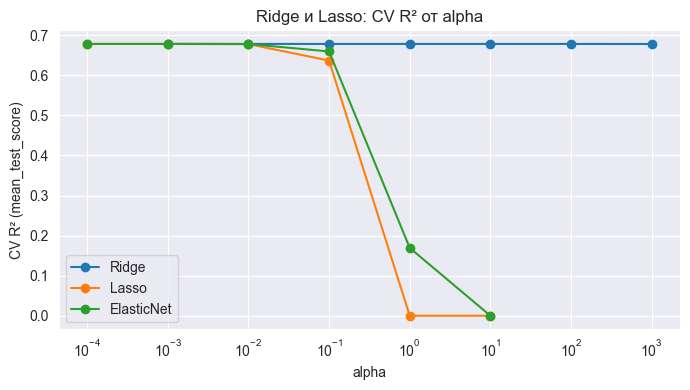

In [100]:
plot_param_curve_multi(
    cv_results_by_model,
    models=["Ridge", "Lasso", "ElasticNet"],
    param_name="param_model__alpha",
    title="Ridge и Lasso: CV R² от alpha",
    log_x=True,
)


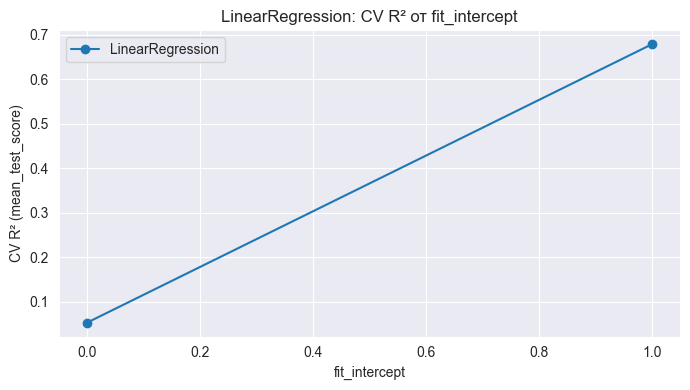

In [63]:
plot_param_curve_multi(
    cv_results_by_model,
    models=["LinearRegression"],
    param_name="param_model__fit_intercept",
    title="LinearRegression: CV R² от fit_intercept",
    log_x=False,
)

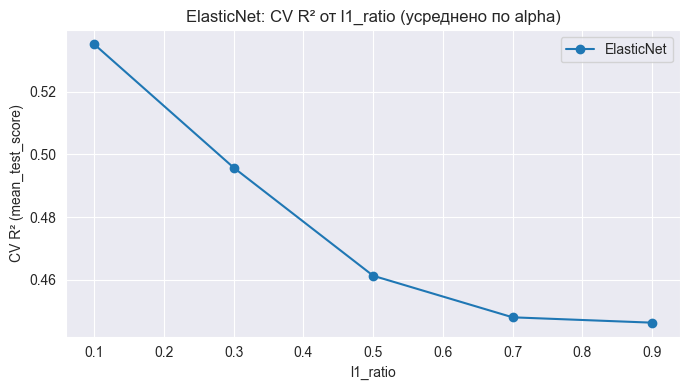

In [101]:
# ElasticNet: R² от alpha (усредняем по l1_ratio)

# ElasticNet: R² от l1_ratio (усреднено по alpha)

plot_param_curve_multi(
    cv_results_by_model,
    models=["ElasticNet"],
    param_name="param_model__l1_ratio",
    title="ElasticNet: CV R² от l1_ratio (усреднено по alpha)",
    log_x=False,
)

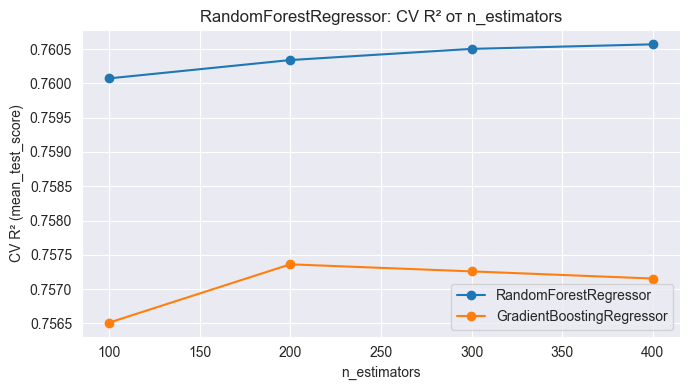

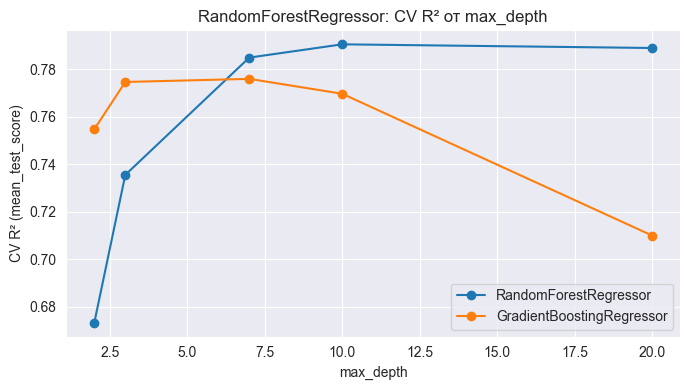

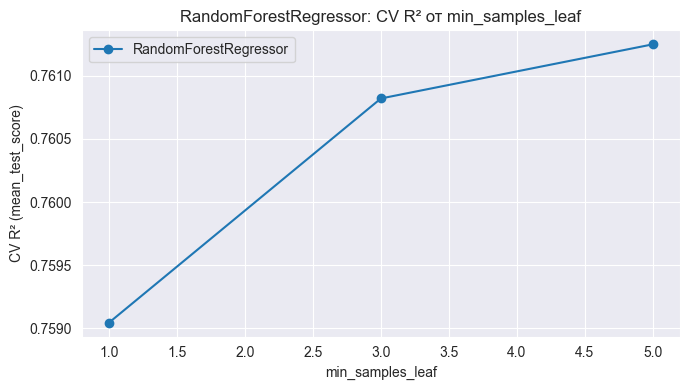

In [108]:
# RF: R² от n_estimators (усреднено по depth/leaf)

plot_param_curve_multi(
    cv_results_by_model,
    models=["RandomForestRegressor", "GradientBoostingRegressor"],
    param_name="param_model__n_estimators",
    title="RandomForestRegressor: CV R² от n_estimators",
    log_x=False,
)

# RF: R² от max_depth (None попадёт как строка, график будет категориальным)

plot_param_curve_multi(
    cv_results_by_model,
    models=["RandomForestRegressor", "GradientBoostingRegressor"],
    param_name="param_model__max_depth",
    title="RandomForestRegressor: CV R² от max_depth",
    log_x=False,
)

# RF: R² от min_samples_leaf

plot_param_curve_multi(
    cv_results_by_model,
    models=["RandomForestRegressor"],
    param_name="param_model__min_samples_leaf",
    title="RandomForestRegressor: CV R² от min_samples_leaf",
    log_x=False,
)

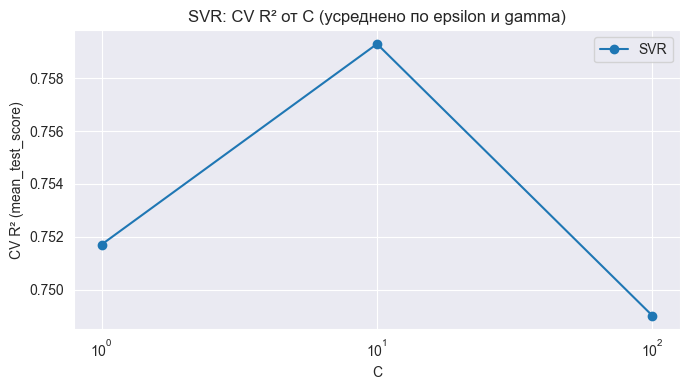

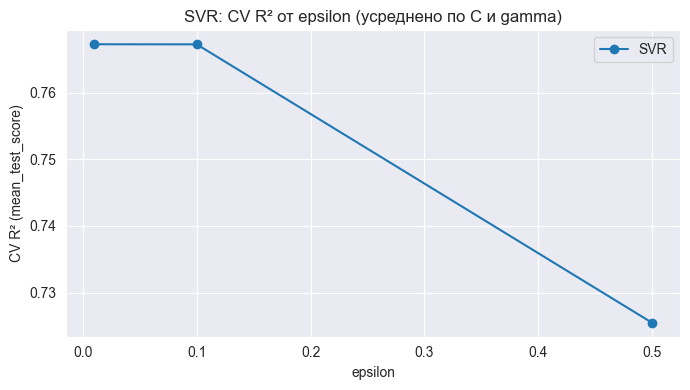

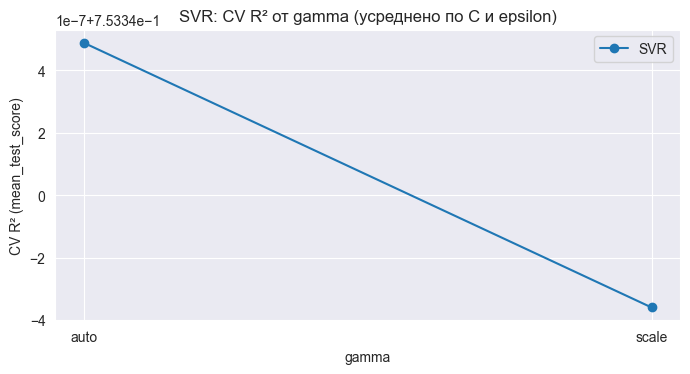

In [67]:
# SVR: R² от C (усреднено по epsilon/gamma)

plot_param_curve_multi(
    cv_results_by_model,
    models=["SVR"],
    param_name="param_model__C",
    title="SVR: CV R² от C (усреднено по epsilon и gamma)",
    log_x=True,
)

# SVR: R² от epsilon

plot_param_curve_multi(
    cv_results_by_model,
    models=["SVR"],
    param_name="param_model__epsilon",
    title="SVR: CV R² от epsilon (усреднено по C и gamma)",
    log_x=False,
)

# SVR: R² от gamma

plot_param_curve_multi(
    cv_results_by_model,
    models=["SVR"],
    param_name="param_model__gamma",
    title="SVR: CV R² от gamma (усреднено по C и epsilon)",
    log_x=False,
)

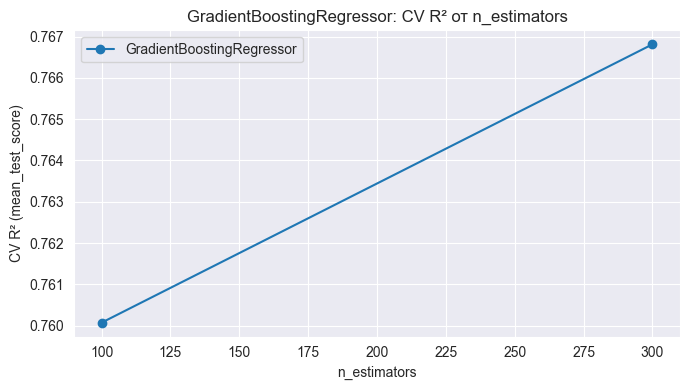

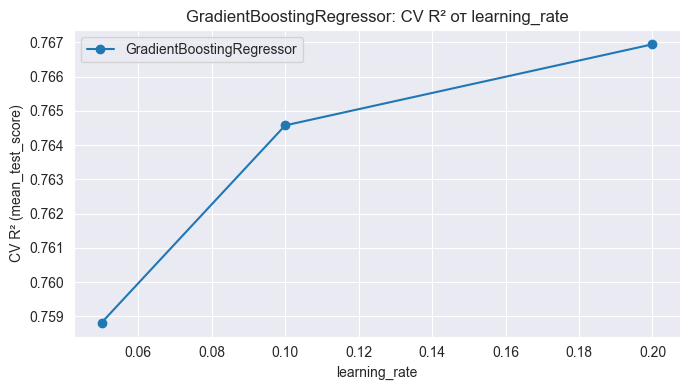

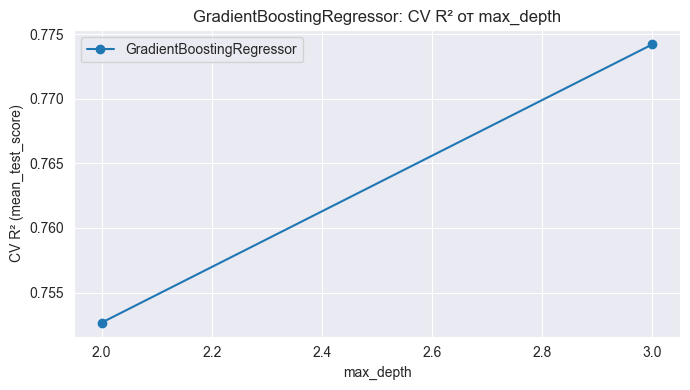

In [68]:

# GBR: R² от learning_rate

plot_param_curve_multi(
    cv_results_by_model,
    models=["GradientBoostingRegressor"],
    param_name="param_model__learning_rate",
    title="GradientBoostingRegressor: CV R² от learning_rate",
    log_x=False,
)

# GBR: R² от max_depth

plot_param_curve_multi(
    cv_results_by_model,
    models=["GradientBoostingRegressor"],
    param_name="param_model__max_depth",
    title="GradientBoostingRegressor: CV R² от max_depth",
    log_x=False,
)

In [98]:
lin_pipe = best_models["LinearRegression"]
scaler = lin_pipe.named_steps["scaler"]
lin_model = lin_pipe.named_steps["model"]

feature_names = all_features_ext

beta_scaled = lin_model.coef_
intercept_scaled = lin_model.intercept_

mean_ = scaler.mean_
scale_ = scaler.scale_

beta_original = beta_scaled / scale_
intercept_original = intercept_scaled - np.sum(beta_scaled * mean_ / scale_)

rows1 = []
for name, c in zip(feature_names, beta_original):
    print(f"{name:15s}: {c:+.6f}")
    rows1.append({
        "feature":name,
        "coeff": c,})  
print("intercept_original:", intercept_original)

df_coeff = pd.DataFrame(rows1)
display(df_coeff)

u              : +0.017361
g              : +0.016004
r              : +0.020116
i              : +0.021152
z              : +0.020532
u_g            : +0.015416
g_r            : -0.005063
r_i            : +0.014717
i_z            : +0.007855
class_STAR     : -0.583808
class_GALAXY   : -0.234912
class_QSO      : +1.011803
intercept_original: -1.2750875566441098


,feature,coeff
0,u,0.017361
1,g,0.016004
2,r,0.020116
3,i,0.021152
4,z,0.020532
5,u_g,0.015416
6,g_r,-0.005063
7,r_i,0.014717
8,i_z,0.007855
9,class_STAR,-0.583808


In [69]:
df_features_ext = pd.DataFrame(
    X_reg_ext,
    columns=all_features_ext
)

# 2. Матрица корреляций
corr = df_features_ext.corr()
display(corr)

# 3. Модуль корреляций и верхний треугольник
corr_abs = corr.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

threshold = 0.95

to_drop_corr = [col for col in upper.columns if any(upper[col] > threshold)]
keep_cols = [c for c in all_features_ext if c not in to_drop_corr]

print("Сильно коррелирующие, которые выкидываем:", to_drop_corr)
print("Оставляем фичи:", keep_cols)
print(f"Было {len(all_features_ext)} фич, осталось {len(keep_cols)}")

,u,g,r,i,z,u_g,g_r,r_i,i_z,class_STAR,class_GALAXY,class_QSO
u,1.000000,0.853350,0.728681,0.618346,0.545760,0.434541,0.526858,0.527479,0.293030,-0.216075,0.272524,-0.114545
g,0.853350,1.000000,0.932996,0.847046,0.775302,-0.098730,0.417732,0.481468,0.285096,-0.261299,0.163133,0.069946
r,0.728681,0.932996,1.000000,0.962868,0.919114,-0.220938,0.062760,0.323293,0.165290,-0.197711,-0.038007,0.255139
i,0.618346,0.847046,0.962868,1.000000,0.971546,-0.283057,-0.081851,0.055813,0.100306,-0.161537,-0.160388,0.370458
z,0.545760,0.775302,0.919114,0.971546,1.000000,-0.297664,-0.170349,-0.006265,-0.138206,-0.129176,-0.219269,0.410242
u_g,0.434541,-0.098730,-0.220938,-0.283057,-0.297664,1.000000,0.283985,0.175064,0.066802,0.038977,0.238361,-0.339476
g_r,0.526858,0.417732,0.062760,-0.081851,-0.170349,0.283985,1.000000,0.519007,0.373330,-0.225487,0.548349,-0.450153
r_i,0.527479,0.481468,0.323293,0.055813,-0.006265,0.175064,0.519007,1.000000,0.259704,-0.164983,0.421624,-0.354932
i_z,0.293030,0.285096,0.165290,0.100306,-0.138206,0.066802,0.373330,0.259704,1.000000,-0.132835,0.250429,-0.174244
class_STAR,-0.216075,-0.261299,-0.197711,-0.161537,-0.129176,0.038977,-0.225487,-0.164983,-0.132835,1.000000,-0.635364,-0.253845


Сильно коррелирующие, которые выкидываем: ['i', 'z']
Оставляем фичи: ['u', 'g', 'r', 'u_g', 'g_r', 'r_i', 'i_z', 'class_STAR', 'class_GALAXY', 'class_QSO']
Было 12 фич, осталось 10


In [70]:
df_features_ext = pd.DataFrame(
    X_reg_ext,          # тот же, что шёл в train_test_split
    columns=all_features_ext
)

In [109]:
def get_corr_based_subset(df_features, threshold=0.95):
    """
    Возвращает список фич, очищенный от сильно коррелирующих (|corr| > threshold).
    Оставляем по одной из каждой пары.
    """
    corr = df_features.corr()
    corr_abs = corr.abs()

    upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    keep = [c for c in df_features.columns if c not in to_drop]

    print(f"[corr {threshold}] выкинули {len(to_drop)} фич: {to_drop}")
    print(f"[corr {threshold}] оставили {len(keep)} фич")
    return keep

In [72]:
features_corr_095 = get_corr_based_subset(df_features_ext, threshold=0.95)
features_corr_098 = get_corr_based_subset(df_features_ext, threshold=0.98)

[corr 0.95] выкинули 2 фич: ['i', 'z']
[corr 0.95] оставили 10 фич
[corr 0.98] выкинули 0 фич: []
[corr 0.98] оставили 12 фич


In [73]:
# достаём обученный RF из пайплайна
rf_pipe = best_models["RandomForestRegressor"]
rf_model = rf_pipe.named_steps["model"]   # т.к. в пайплайне шаг назывался "model"

rf_importances = rf_model.feature_importances_
rf_importances_series = pd.Series(rf_importances, index=all_features_ext).sort_values(ascending=False)

display(rf_importances_series)

class_QSO       0.677890
g               0.083386
u_g             0.066259
r_i             0.042877
class_GALAXY    0.027622
g_r             0.025158
r               0.019573
class_STAR      0.015020
z               0.011271
i_z             0.010998
i               0.010094
u               0.009854
dtype: float64

In [76]:
def get_rf_cumulative_subsets(importances_series, thresholds=(0.9, 0.95, 0.99)):
    subsets = {}
    cum = importances_series.cumsum()
    for thr in thresholds:
        mask = cum <= thr
        # обязательно включим ту фичу, на которой порог пересекли
        if not mask.iloc[-1]:
            idx_last = np.where(mask.values)[0].max()
            selected = list(importances_series.index[:idx_last+1])
        else:
            selected = list(importances_series.index)
        subsets[f"rf_cum_{int(thr*100)}"] = selected
    return subsets

rf_cum_subsets = get_rf_cumulative_subsets(rf_importances_series, thresholds=(0.9, 0.95, 0.99))
print(rf_cum_subsets)

{'rf_cum_90': ['class_QSO', 'g', 'u_g', 'r_i', 'class_GALAXY'], 'rf_cum_95': ['class_QSO', 'g', 'u_g', 'r_i', 'class_GALAXY', 'g_r', 'r'], 'rf_cum_99': ['class_QSO', 'g', 'u_g', 'r_i', 'class_GALAXY', 'g_r', 'r', 'class_STAR', 'z', 'i_z']}


In [86]:
df_reg.groupby("class")["redshift"].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
GALAXY,59445.0,0.421596,0.264858,-0.009971,0.164527,0.456274,0.594699,1.995524
QSO,18961.0,1.719676,0.913954,0.000461,1.106605,1.617232,2.220279,7.011245
STAR,21593.0,-0.000115,0.000465,-0.004136,-0.000295,-0.000076,0.000075,0.004153


In [77]:
enet_pipe = best_models["ElasticNet"]
enet_model = enet_pipe.named_steps["model"]
enet_coef = enet_model.coef_

lasso_pipe = best_models["Lasso"]
lasso_model = lasso_pipe.named_steps["model"]
lasso_coef = lasso_model.coef_

In [78]:
def get_nonzero_coef_features(coef, feature_names, tol=1e-6):
    coef = np.asarray(coef)
    mask = np.abs(coef) > tol
    return [f for f, m in zip(feature_names, mask) if m]

features_enet_nonzero = get_nonzero_coef_features(enet_coef, all_features_ext, tol=1e-6)
features_lasso_nonzero = get_nonzero_coef_features(lasso_coef, all_features_ext, tol=1e-6)

print("ElasticNet ненулевые:", len(features_enet_nonzero))
print(features_enet_nonzero)
print("Lasso ненулевые:", len(features_lasso_nonzero))
print(features_lasso_nonzero)

ElasticNet ненулевые: 7
['u', 'r', 'i', 'z', 'g_r', 'class_STAR', 'class_QSO']
Lasso ненулевые: 7
['u', 'r', 'i', 'z', 'g_r', 'class_STAR', 'class_QSO']


In [94]:
feature_subsets = {}

# 0. Базовый вариант: все фичи
feature_subsets["all_features"] = list(all_features_ext)

# 1. Корреляционные сеты
feature_subsets["corr_095"] = features_corr_095
feature_subsets["corr_098"] = features_corr_098

# 2. RF по важности
feature_subsets.update(rf_cum_subsets)

# 3. Lasso / ElasticNet
feature_subsets["enet_nonzero"] = features_enet_nonzero
feature_subsets["lasso_nonzero"] = features_lasso_nonzero



import textwrap

rows = []
for name, feats in feature_subsets.items():
    wrapped = "\n".join(textwrap.wrap(", ".join(feats), width=180))
    rows.append({
        "subset": name,
        "n_features": len(feats),
        "features": wrapped,
    })

df_subsets = pd.DataFrame(rows).sort_values("n_features")
display(df_subsets)

,subset,n_features,features
3,rf_cum_90,5,"class_QSO, g, u_g, r_i, class_GALAXY"
4,rf_cum_95,7,"class_QSO, g, u_g, r_i, class_GALAXY, g_r, r"
6,enet_nonzero,7,"u, r, i, z, g_r, class_STAR, class_QSO"
7,lasso_nonzero,7,"u, r, i, z, g_r, class_STAR, class_QSO"
1,corr_095,10,"u, g, r, u_g, g_r, r_i, i_z, class_STAR, class..."
5,rf_cum_99,10,"class_QSO, g, u_g, r_i, class_GALAXY, g_r, r, ..."
0,all_features,12,"u, g, r, i, z, u_g, g_r, r_i, i_z, class_STAR,..."
2,corr_098,12,"u, g, r, i, z, u_g, g_r, r_i, i_z, class_STAR,..."


## Выбор моделей для работы

In [80]:
selected_model_names = [
    "LinearRegression",
    "Ridge",
    "Lasso",
    "RandomForestRegressor",
    "GradientBoostingRegressor",
    "ElasticNet",
    
]

selected_model_configs = {
    name: model_configs[name] for name in selected_model_names
}

In [81]:
subset_results = []  # здесь будет: subset_name, n_features, model_name, R2, RMSE, MAE

for subset_name, feat_list in feature_subsets.items():
    # индекс фич по именам → по колонкам
    cols_idx = [all_features_ext.index(f) for f in feat_list]
    
    X_train_sub = X_train_r[:, cols_idx]
    X_test_sub = X_test_r[:, cols_idx]

    for model_name, cfg in selected_model_configs.items():
        scaler_step = StandardScaler() if cfg["use_scaler"] else "passthrough"
        pipe = Pipeline([
            ("scaler", scaler_step),
            ("model", cfg["estimator"]),
        ])

        gs = GridSearchCV(
            estimator=pipe,
            param_grid=cfg["param_grid"],
            scoring="r2",
            cv=3,
            n_jobs=-1,
            verbose=0,
        )
        gs.fit(X_train_sub, y_train_r)
        best_est = gs.best_estimator_

        y_pred = best_est.predict(X_test_sub)
        r2, mse, rmse, mae = reg_metrics(y_test_r, y_pred)

        subset_results.append({
            "subset": subset_name,
            "n_features": len(feat_list),
            "model": model_name,
            "test_r2": r2,
            "test_rmse": rmse,
            "test_mae": mae,
        })

subset_results_df = pd.DataFrame(subset_results)
display(subset_results_df)

/Users/zuha/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/zuha/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/zuha/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/zuha/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeou

,subset,n_features,model,test_r2,test_rmse,test_mae
0,all_features,12,LinearRegression,0.667472,0.423059,0.227339
1,all_features,12,Ridge,0.667472,0.423059,0.227338
2,all_features,12,Lasso,0.667523,0.423027,0.227033
3,all_features,12,RandomForestRegressor,0.779341,0.344626,0.121104
4,all_features,12,GradientBoostingRegressor,0.766248,0.354703,0.140183
5,all_features,12,ElasticNet,0.667520,0.423029,0.227063
6,corr_095,10,LinearRegression,0.667472,0.423059,0.227339
7,corr_095,10,Ridge,0.667472,0.423059,0.227335
8,corr_095,10,Lasso,0.667535,0.423019,0.226827
9,corr_095,10,RandomForestRegressor,0.778640,0.345173,0.121060


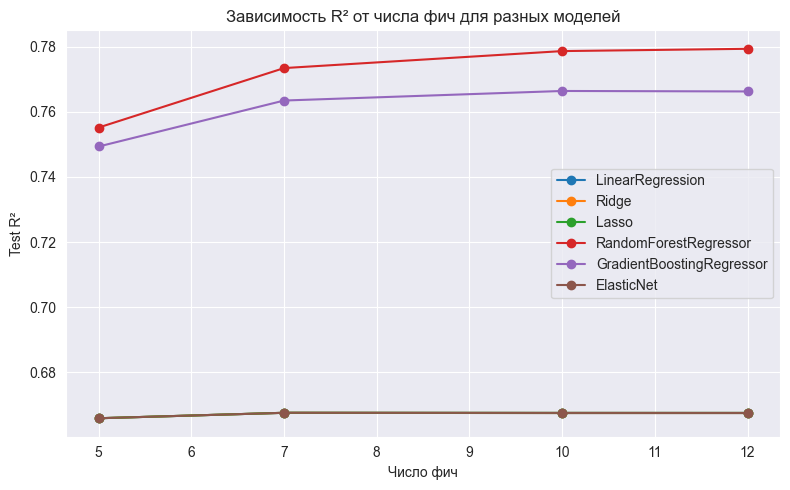

In [83]:
plt.figure(figsize=(8, 5))

for model_name in subset_results_df["model"].unique():
    df_m = subset_results_df[subset_results_df["model"] == model_name].copy()
    df_m = df_m.sort_values("n_features")

    # Чтобы при одинаковом n_features и разных subset'ах не было каши,
    # агрегируем по максимуму R² для данной модели и числа фич
    df_agg = (
        df_m.groupby("n_features")["test_r2"]
        .max()
        .reset_index()
        .sort_values("n_features")
    )

    plt.plot(
        df_agg["n_features"],
        df_agg["test_r2"],
        marker="o",
        label=model_name,
    )

plt.xlabel("Число фич")
plt.ylabel("Test R²")
plt.title("Зависимость R² от числа фич для разных моделей")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

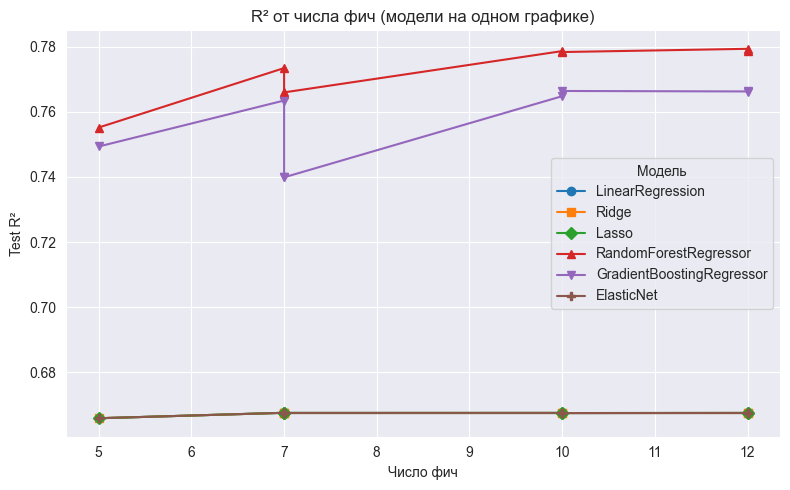

In [99]:
plt.figure(figsize=(8, 5))

markers = ["o", "s", "D", "^", "v", "P", "X"]
marker_map = {}

for i, model_name in enumerate(subset_results_df["model"].unique()):
    df_m = subset_results_df[subset_results_df["model"] == model_name].copy()
    df_m = df_m.sort_values("n_features")

    marker = markers[i % len(markers)]
    marker_map[model_name] = marker

    plt.plot(
        df_m["n_features"],
        df_m["test_r2"],
        marker=marker,
        linestyle="-",
        label=model_name,
    )

    # Подписи subset'ов
    # for _, row in df_m.iterrows():
    #     plt.text(
    #         row["n_features"],
    #         row["test_r2"],
    #         row["subset"],
    #         fontsize=7,
    #         ha="left",
    #         va="bottom",
    #     )

plt.xlabel("Число фич")
plt.ylabel("Test R²")
plt.title("R² от числа фич (модели на одном графике)")
plt.grid(True)
plt.legend(title="Модель")
plt.tight_layout()
plt.show()

In [23]:
# Индексы оставляемых признаков в исходном порядке
keep_idx = [feature_cols.index(c) for c in keep_cols]

X_train_red = X_train_r[:, keep_idx]
X_test_red = X_test_r[:, keep_idx]

print("Исходная форма:", X_train_r.shape, "→ после ресайза:", X_train_red.shape)

Исходная форма: (79999, 5) → после ресайза: (79999, 3)


In [24]:
def reg_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, mse, rmse, mae

def get_best_params(model_name):
    row = df_models[df_models["model"] == model_name].iloc[0]
    params = row["best_params"].copy()  # dict
    # убираем префикс 'model__'
    params = {k.replace("model__", ""): v for k, v in params.items()}
    return params


def eval_on_reduced_features(model_name, estimator_cls, use_scaler=True):
    best_params = get_best_params(model_name)
    model = estimator_cls(**best_params)

    steps = []
    if use_scaler:
        steps.append(("scaler", StandardScaler()))
    steps.append(("model", model))

    pipe = Pipeline(steps)
    pipe.fit(X_train_red, y_train_r)
    y_pred = pipe.predict(X_test_red)

    r2, mse, rmse, mae = reg_metrics(y_test_r, y_pred)
    print(f"{model_name} (reduced): R2={r2:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}")
    return dict(
        model=model_name + "_reduced",
        r2=r2,
        mse=mse,
        rmse=rmse,
        mae=mae,
        n_features=len(keep_cols),
    )

reduced_results = []

# 1. RandomForestRegressor — без скейлера
reduced_results.append(
    eval_on_reduced_features("RandomForestRegressor", RandomForestRegressor, use_scaler=False)
)

# 2. GradientBoostingRegressor — тоже без скейлера
reduced_results.append(
    eval_on_reduced_features("GradientBoostingRegressor", GradientBoostingRegressor, use_scaler=False)
)

# 3. SVR — со скейлером
reduced_results.append(
    eval_on_reduced_features("SVR", SVR, use_scaler=True)
)

df_reduced = pd.DataFrame(reduced_results)
display(df_reduced)

RandomForestRegressor (reduced): R2=0.3672, RMSE=0.5890, MAE=0.2831
GradientBoostingRegressor (reduced): R2=0.3553, RMSE=0.5945, MAE=0.3011
SVR (reduced): R2=0.2852, RMSE=0.6260, MAE=0.2872


,model,r2,mse,rmse,mae,n_features
0,RandomForestRegressor_reduced,0.367156,0.346953,0.589027,0.283089,3
1,GradientBoostingRegressor_reduced,0.355283,0.353462,0.594527,0.301148,3
2,SVR_reduced,0.285209,0.391879,0.626003,0.287197,3


In [25]:
import itertools


feature_cols = ['u', 'g', 'r', 'i', 'z']   # твои 5 фич

rf_params = get_best_params("RandomForestRegressor")  # как раньше
results_subsets = []

def reg_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, mse, rmse, mae

for k in range(1, len(feature_cols) + 1):
    for subset in itertools.combinations(feature_cols, k):
        idx = [feature_cols.index(f) for f in subset]
        X_train_k = X_train_r[:, idx]
        X_test_k = X_test_r[:, idx]

        rf_k = RandomForestRegressor(**rf_params, n_jobs=-1)
        rf_k.fit(X_train_k, y_train_r)
        y_pred_k = rf_k.predict(X_test_k)

        r2, mse, rmse, mae = reg_metrics(y_test_r, y_pred_k)

        results_subsets.append({
            "n_features": k,
            "features": subset,
            "r2": r2,
            "rmse": rmse,
            "mae": mae,
        })

df_subsets = pd.DataFrame(results_subsets).sort_values("r2", ascending=False)
display(df_subsets.head(10))

,n_features,features,r2,rmse,mae
30,5,"(u, g, r, i, z)",0.435849,0.556140,0.255508
26,4,"(u, g, r, z)",0.414761,0.566439,0.263068
25,4,"(u, g, r, i)",0.412126,0.567713,0.262851
27,4,"(u, g, i, z)",0.410874,0.568317,0.271398
28,4,"(u, r, i, z)",0.396658,0.575133,0.274138
29,4,"(g, r, i, z)",0.383719,0.581267,0.280814
16,3,"(u, g, i)",0.379866,0.583082,0.283298
17,3,"(u, g, z)",0.370948,0.587260,0.288304
18,3,"(u, r, i)",0.370402,0.587514,0.283126
19,3,"(u, r, z)",0.366645,0.589265,0.285241
